# Evaluation of GRN inference methods
## Supplementary analysis
### by Jalil Nourisa



# Imports

In [1]:
!cd ../ && source env.sh

Wrote env.yaml


In [2]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import anndata as ad
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scanpy as sc 
import itertools
import warnings
import os
import warnings
from scipy import stats
warnings.filterwarnings("ignore") #all warnings
plt.rcParams['font.family'] = 'Arial' # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# - local imports (task_grn_inference should be along side this repo)
from grn_benchmark.src.helper import load_env
env = load_env()

# Check if env['GRN_BENCHMARK_DIR'] exists
if 'GRN_BENCHMARK_DIR' not in env:
    raise KeyError("GRN_BENCHMARK_DIR not found in environment variables")
if not os.path.exists(env['GRN_BENCHMARK_DIR']):
    raise FileNotFoundError(f"GRN_BENCHMARK_DIR path does not exist: {env['GRN_BENCHMARK_DIR']}")

sys.path.append(env['GRN_BENCHMARK_DIR'])
from src.helper import plot_heatmap, surrogate_names, custom_jointplot, palette_celltype, \
                       palette_methods, \
                       palette_datasets, colors_blind, linestyle_methods, palette_datasets, CONTROLS3, linestyle_methods, retrieve_grn_path, \
                        plot_raw_scores
from src.params import get_par

TASK_GRN_INFERENCE_DIR = env['TASK_GRN_INFERENCE_DIR']
sys.path.append(TASK_GRN_INFERENCE_DIR)
from src.utils.util import naming_convention
from src.utils.config import DATASETS, METRICS, METHODS, FINAL_METRICS
# from src.utils.util import 
from src.exp_analysis.helper import Exp_analysis, create_interaction_info, jaccard_similarity_net

# - ordered names
from pandas.api.types import CategoricalDtype
category_order_reg1 = CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Positive Ctrl', 'Pearson Corr.', 'GRaNIE'], ordered=True)
category_order_reg2 = CategoricalDtype(categories=['GRNBoost2', 'Positive Ctrl', 'Pearson Corr.', 'PPCOR'], ordered=True)

# - variables
perturb_col = 'perturbation'

# - directories
RESULTS_DIR = env['RESULTS_DIR']
figs_dir = F"{env['RESULTS_DIR']}/figs"
os.makedirs(figs_dir, exist_ok=True)
%matplotlib inline

surrogate_names['gs_precision']


['Arial']


python-dotenv could not parse statement starting at line 2
python-dotenv could not parse statement starting at line 41
python-dotenv could not parse statement starting at line 44
python-dotenv could not parse statement starting at line 45
python-dotenv could not parse statement starting at line 46
python-dotenv could not parse statement starting at line 48


'GS (precision)'

# Ensemble

In [4]:
rr_folder = f"{env['RESULTS_DIR']}/experiment/ensemble"
dataset = 'op'
os.makedirs(rr_folder, exist_ok=True)

In [11]:
!cd ../ && bash scripts/experiment_ensemble.sh --rr_folder {rr_folder} --dataset {dataset}

Wrote env.yaml
Original net shape:  (66059, 3)
Supplementary columns for grouping: []
/home/jnourisa/projs/ongoing/task_grn_inference/src/utils/util.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net["weight"] = pd.to_numeric(net["weight"], errors='coerce')
Network shape after cleaning: (65919, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
Original net shape:  (50000, 3)
Supplementary columns for grouping: []
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
Total edges from all methods: 150000
Unique edges after combining: 116581
Edges in 1 

In [29]:
!ls -lt {rr_folder}

total 2552
-rw-r--r-- 1 jnourisa clusers   23048 Dec 12 04:26 score_consensus_op.h5ad
-rw-r--r-- 1 jnourisa clusers 4403176 Dec 12 04:22 op.consensus.consensus.prediction.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 24 14:49 score_pearson_corr_op.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 24 14:30 score_grnboost_op.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 24 14:10 score_scenicplus_op.h5ad


Loading: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/ensemble/score_scenicplus_op.h5ad
Loading: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/ensemble/score_pearson_corr_op.h5ad
Loading: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/ensemble/score_grnboost_op.h5ad
Loading: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/ensemble/score_consensus_op.h5ad


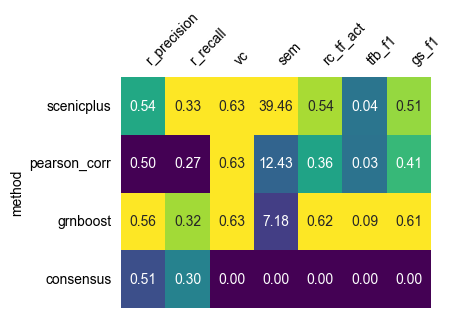

In [12]:
# loop over every score file in results directory
import glob
all_scores = glob.glob(f"{rr_folder}/score_*_{dataset}.h5ad")
score_objs = {}
df_store = []
for sf in all_scores:
    print("Loading:", sf)
    score = ad.read_h5ad(sf)
    metric_ids = score.uns['metric_ids']
    metric_values = score.uns['metric_values']
    df = pd.DataFrame([metric_values], columns=metric_ids)
    df['method'] = score.uns['method_id']
    df_store.append(df)
final_df = pd.concat(df_store, axis=0)  
df = final_df.set_index('method')[[c for c in FINAL_METRICS if c in final_df.columns]].fillna(0)
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)
plot_heatmap(df, name='', ax=ax, cmap="viridis")

# Causality analysis

- read small sc train data for replogle and xaira
- infer grn per dataset per one of the conditions of: 1. only control, 2. only perturb, 3. perturb + control
- for each, take top 50k with and without filtering for TFs
- for each dataset, run the consensus between the models 
- run the metrics

In [9]:
!cd ../ && sbatch scripts/experiment_causality.sh 

Submitted batch job 9103078


In [17]:
!du -ah --max-depth 1 {env['RESULTS_DIR']}/experiment/ | sort -hr

7.9G	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/
5.5G	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/imputation
2.2G	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/granular_pseudobulk
76M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/global_grns
56M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/causality
39M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/permute_grn
19M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/metrics_stability
19M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/bulk_vs_sc
15M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/normalization
2.4M	/home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/ws_consistency
2.0M	/home/jnourisa/projs/ongoing/task_grn_inference/resources

In [54]:
df = pd.read_csv(f"{env['RESULTS_DIR']}/experiment/causality/scores.csv", index_col=0)
df = df.drop('r2_raw', axis=1)
df

,r_precision,r_recall,r_f1,method,dataset_mask,dataset
0,0.094231,0.036639,0.052762,pearson_tf_applied,ctr,xaira_HEK293T
0,0.044054,0.020228,0.027725,pearson,ctr,xaira_HEK293T
0,0.094345,0.036684,0.052827,pearson_tf_applied,pert,xaira_HEK293T
0,0.044086,0.020031,0.027546,pearson,pert,xaira_HEK293T
0,0.094393,0.036640,0.052789,pearson_tf_applied,both,xaira_HEK293T
0,0.043979,0.020142,0.027629,pearson,both,xaira_HEK293T
0,0.086412,0.050879,0.064047,pearson_tf_applied,ctr,xaira_HCT116
0,0.033289,0.024114,0.027968,pearson,ctr,xaira_HCT116
0,0.086502,0.051183,0.064312,pearson_tf_applied,pert,xaira_HCT116
0,0.033236,0.024075,0.027923,pearson,pert,xaira_HCT116


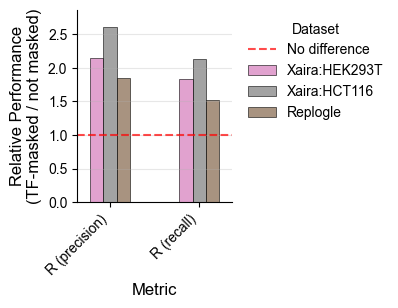

In [57]:
# Filter for dataset_mask == 'pert'
df_pert = df[df['dataset_mask'] == 'pert'].copy()

# Prepare data for plotting
metrics_cols = ['r_precision', 'r_recall']
df_plot = df_pert[['dataset', 'method'] + metrics_cols].copy()

# Calculate relative performance (TF masked / TF not masked)
datasets = df_plot['dataset'].unique()
relative_data = []

for dataset in datasets:
    dataset_data = df_plot[df_plot['dataset'] == dataset]
    
    tf_masked = dataset_data[dataset_data['method'] == 'pearson_tf_applied']
    not_masked = dataset_data[dataset_data['method'] == 'pearson']
    
    if len(tf_masked) > 0 and len(not_masked) > 0:
        for metric in metrics_cols:
            tf_val = tf_masked[metric].values[0]
            not_tf_val = not_masked[metric].values[0]
            
            # Calculate ratio (handle division by zero)
            if not_tf_val != 0 and not np.isnan(tf_val) and not np.isnan(not_tf_val):
                ratio = tf_val / not_tf_val
                relative_data.append({
                    'dataset': dataset,
                    'metric': metric,
                    'relative_performance': ratio
                })

# Create DataFrame
df_relative = pd.DataFrame(relative_data)

# Apply surrogate names
df_relative['dataset'] = df_relative['dataset'].map(lambda x: surrogate_names.get(x, x))
df_relative['metric'] = df_relative['metric'].map(lambda x: surrogate_names.get(x, x))

# Order metrics according to METRICS
ordered_metric_names = [surrogate_names.get(m, m) for m in METRICS if surrogate_names.get(m, m) in df_relative['metric'].unique()]
df_relative['metric'] = pd.Categorical(df_relative['metric'], categories=ordered_metric_names, ordered=True)
df_relative = df_relative.sort_values('metric')

datasets_plot = df_relative['dataset'].unique()
metrics_plot = ordered_metric_names

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))
x = np.arange(len(metrics_plot))  # Metric positions
width = 0.15  # Width of each bar
dataset_colors = [palette_datasets.get(ds, colors_blind[i % len(colors_blind)]) 
                  for i, ds in enumerate(datasets)]

for i, dataset in enumerate(datasets_plot):
    dataset_data = df_relative[df_relative['dataset'] == dataset]
    ratios = []
    for metric in metrics_plot:
        metric_dataset = dataset_data[dataset_data['metric'] == metric]
        if len(metric_dataset) > 0:
            ratios.append(metric_dataset['relative_performance'].values[0])
        else:
            ratios.append(np.nan)
    offset = width * i
    original_dataset = [d for d in datasets if surrogate_names.get(d, d) == dataset][0]
    color = palette_datasets.get(original_dataset, colors_blind[i % len(colors_blind)])
    ax.bar(x + offset, ratios, width, label=dataset, 
           color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No difference')
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Relative Performance\n(TF-masked / not masked)', fontsize=12)
ax.set_xticks(x + width * (len(datasets_plot) - 1) / 2)
ax.set_xticklabels(metrics_plot, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=10, title='Dataset')
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(x=0.1, y=0.1)
plt.savefig(f"{figs_dir}/causality_relative_performance.png", dpi=300, bbox_inches='tight')

# Metrics overview

In [3]:
from task_grn_inference.src.utils.config import METRICS_DATASETS

In [6]:
table_data = [
    {
        "Metric": surrogate_names['regression'],
        "Summary": "Regression-based evaluation of GRN predictions. Evaluateds a GRN by the ability of TFs to predict target gene expression.",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['regression']]),
        "Dataset Type Required": surrogate_names['bulk'],
        "Required Inputs": ", ".join([surrogate_names[i] for i in ['prediction', 'evaluation_data', 'tf_all', 'regulators_consensus']])
    },
    {
        "Metric": surrogate_names['ws_distance'],
        "Summary": "Wasserstein distance between control and perturbed gene expression distributions to evaluate GRN predictions.",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['ws_distance']]),
        "Dataset Type Required": surrogate_names['sc'],
        "Required Inputs": ", ".join([surrogate_names[i] for i in ['prediction', 'ws_consensus', 'ws_distance_background']])
    },
    {
        "Metric": surrogate_names['sem'],
        "Summary": "Structural Equation Modeling for GRN evaluation.",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['sem']]),
        "Dataset Type Required": surrogate_names['bulk'],
        "Required Inputs": ", ".join([surrogate_names[i] for i in ['prediction', 'evaluation_data', 'tf_all']])
    },
    {
        "Metric": surrogate_names['vc'],
        "Summary": "Evalute GRNs by their ability in predicting gene expression through neural networks-based virtual cell model.",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['vc']]),
        "Dataset Type Required": surrogate_names['bulk'],
        "Required Inputs": ", ".join([surrogate_names[i] for i in ['prediction', 'evaluation_data']])
    },
    {
        "Metric": surrogate_names['tf_recovery'],
        "Summary": "Measures ability to recover TFs using differential expression and GRN.",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['tf_recovery']]),
        "Dataset Type Required": surrogate_names['de'],
        "Required Inputs": ", ".join([surrogate_names[i] for i in ['prediction', 'evaluation_data_de', 'tf_all']])
    },
    {
        "Metric": surrogate_names['rc_tf_act'],
        "Summary": "Measures consistency of GRN predictions across biological replicates/groups.",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['rc_tf_act']]),
        "Dataset Type Required": surrogate_names['sc'],
        "Required Inputs": ", ".join([surrogate_names[i] for i in ['prediction', 'evaluation_data']])
    },
    {
        "Metric": surrogate_names['gs_recovery'],
        "Summary": "Evaluates GRNs by their ability to recover known gene sets",
        "Applicable Datasets": ", ".join([surrogate_names.get(ds, ds) for ds in METRICS_DATASETS['gs_recovery']]),
        "Dataset Type Required": surrogate_names['bulk'],
        "Required Inputs": ", ".join([surrogate_names.get(i, i) for i in ['prediction', 'evaluation_data', 'Genesets']])
    }
]

import pandas as pd
import textwrap

# Set max column width for display
pd.set_option('display.max_colwidth', 40)  # Change 40 to your desired width

# Optionally wrap text in columns for Markdown output
def wrap_df_columns(df, width=40):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: '\n'.join(textwrap.wrap(str(x), width)))
    return df

df = pd.DataFrame(table_data)
df = wrap_df_columns(df, width=40)
print(df.to_markdown(index=False))

| Metric              | Summary                                  | Applicable Datasets                      | Dataset Type Required   | Required Inputs                          |
|:--------------------|:-----------------------------------------|:-----------------------------------------|:------------------------|:-----------------------------------------|
| Regression          | Regression-based evaluation of GRN       | Replogle, Norman, Nakatake, OPSCA,       | Bulk                    | Inferred GRN, Evaluation data, Known TFs |
|                     | predictions. Evaluateds a GRN by the     | 300BCG, IBD:UC, IBD:CD, ParseBioscience, |                         | list, Consensus regulators (Regression)  |
|                     | ability of TFs to predict target gene    | Xaira:HEK293T, Xaira:HCT116              |                         |                                          |
|                     | expression.                              |                                       

# Gene set recovery

In [ ]:
!cd {env['TASK_GRN_INFERENCE_DIR']} && bash src/metrics/experimental/gs_recovery/run_global.sh

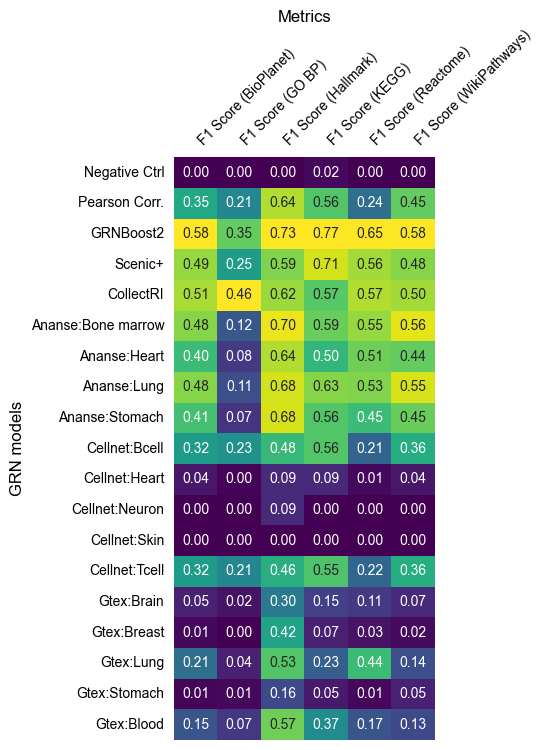

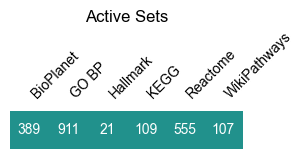

In [3]:
output_dir = f"{env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/gs_recovery/"
metric = 'gs_recovery'
sets = ['reactome_2022', 'bioplanet_2019', 'wikipathways_2019', 'kegg_2021', 'go_bp_2023', 'hallmark_2020']

# Prettier names mapping
pretty_names = {
    'reactome_2022': 'Reactome',
    'bioplanet_2019': 'BioPlanet',
    'wikipathways_2019': 'WikiPathways',
    'kegg_2021': 'KEGG',
    'go_bp_2023': 'GO BP',
    'hallmark_2020': 'Hallmark'
}

# Method ordering: inferred GRNs first, then global ones
method_order = ['negative_control', 'pearson_corr', 'grnboost', 'scenicplus', 'collectri']

df_all = pd.read_csv(f'{output_dir}/summary_global.csv')
for dataset in df_all['dataset'].unique():
    df = df_all[df_all['dataset'] == dataset]
    df = df.pivot(index='method', columns='metric', values='value')
    
    # Collect columns by type
    precision_cols = [col for col in df.columns if 'gs_precision' in col]
    recall_cols = [col for col in df.columns if 'gs_recall' in col]
    active_cols = [col for col in df.columns if 'gs_n_active' in col]
    f1_cols = [col for col in df.columns if 'gs_f1' in col]
    
    # Main plot: precision and recall only
    cols_main =  f1_cols
    df_main = df[cols_main].copy()
    
    # Rename columns with prettier names
    new_col_names = {}
    for col in df_main.columns:
        source = col.replace('_gs_precision', '').replace('_gs_recall', '').replace('_gs_f1', '')
        pretty_source = pretty_names.get(source, source)
        if 'gs_precision' in col:
            new_col_names[col] = f'Precision ({pretty_source})'
        elif 'gs_recall' in col:
            new_col_names[col] = f'Recall ({pretty_source})'
        elif 'gs_f1' in col:
            new_col_names[col] = f'F1 Score ({pretty_source})'
    df_main = df_main.rename(columns=new_col_names)
    
    # Order methods: specified ones first, then the rest
    available_methods = df_main.index.tolist()
    ordered_methods = [m for m in method_order if m in available_methods]
    remaining_methods = [m for m in available_methods if m not in method_order]
    final_method_order = ordered_methods + remaining_methods
    df_main = df_main.reindex(final_method_order)
    df_main.index = df_main.index.map(lambda x: surrogate_names.get(x, x))
    
    # Plot main heatmap (precision and recall)
    fig, ax = plt.subplots(figsize=(.9*len(df_main.columns), .4*len(df_main)))
    plot_heatmap(df_main, name='',  cmap="viridis", ax=ax)
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('GRN models', fontsize=12)
    plt.tight_layout()
    
    # Separate plot for active sets (constant across methods)
    if active_cols:
        df_active = df[active_cols].copy()
        new_col_names_active = {}
        for col in df_active.columns:
            source = col.replace('_gs_n_active', '')
            pretty_source = pretty_names.get(source, source)
            new_col_names_active[col] = pretty_source
        df_active = df_active.rename(columns=new_col_names_active)
        
        # Take first row since it's constant
        df_active_display = df_active.iloc[:1]
        
        fig, ax = plt.subplots(figsize=(.5*len(df_active_display.columns), 0.5))
        df_active_display = df_active_display.astype(int)
        plot_heatmap(df_active_display, name='',  cmap="viridis", ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        plt.title(f'Active Sets')
        plt.tight_layout()


# TF binding

In [30]:
!ls {TASK_GRN_INFERENCE_DIR}/resources/datasets_raw/tfb

chipatlas  remap2022  unibind


## Stats: TF target

In [17]:
# Define cell types and their corresponding ground truth files
cell_types_info = {
    'PBMC': {'gt_files': ['PBMC_remap.csv', 'PBMC_chipatlas.csv', 'PBMC_unibind.csv']},
    'K562': {'gt_files': ['K562_remap.csv', 'K562_chipatlas.csv', 'K562_unibind.csv']},
    'HEK293': {'gt_files': ['HEK293T_remap.csv', 'HEK293T_chipatlas.csv', 'HEK293T_unibind.csv']},
    'HCT116': {'gt_files': ['HCT116_remap.csv', 'HCT116_chipatlas.csv', 'HCT116_unibind.csv']}
}

ground_truth_types = ['remap2022', 'chipatlas', 'unibind']
gt_base_path = f'{TASK_GRN_INFERENCE_DIR}/resources/grn_benchmark/ground_truth/'

# Collect statistics for each cell type and ground truth type
stats_data = []

for cell_type, info in cell_types_info.items():
    print(f"Processing cell type: {cell_type}")
    
    for i, gt_type in enumerate(ground_truth_types):
        gt_file = info['gt_files'][i]
        gt_path = f"{gt_base_path}/{gt_file}"
        
        if os.path.exists(gt_path):
            try:
                # Read ground truth file
                df = pd.read_csv(gt_path)
                
                # Count unique TFs
                n_tfs = df['source'].nunique()
                n_edges = len(df)
                n_targets = df['target'].nunique()
                
                stats_data.append({
                    'cell_type': cell_type,
                    'ground_truth': gt_type,
                    'n_tfs': n_tfs,
                    'n_edges': n_edges,
                    'n_targets': n_targets,
                    'avg_targets_per_tf': n_edges / n_tfs if n_tfs > 0 else 0
                })
                
                print(f"  {gt_type}: {n_tfs} TFs, {n_edges} edges, {n_targets} targets")
                
            except Exception as e:
                print(f"  Error reading {gt_file}: {e}")
                stats_data.append({
                    'cell_type': cell_type,
                    'ground_truth': gt_type,
                    'n_tfs': 0,
                    'n_edges': 0,
                    'n_targets': 0,
                    'avg_targets_per_tf': 0
                })
        else:
            print(f"  File not found: {gt_file}")
            stats_data.append({
                'cell_type': cell_type,
                'ground_truth': gt_type,
                'n_tfs': 0,
                'n_edges': 0,
                'n_targets': 0,
                'avg_targets_per_tf': 0
            })

# Convert to DataFrame
stats_df = pd.DataFrame(stats_data)
print(f"\nCollected stats for {len(stats_df)} cell type-GT combinations")
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
print(stats_df.pivot_table(index='cell_type', columns='ground_truth', values='n_tfs', fill_value=0))
stats_df


Processing cell type: PBMC
  remap2022: 12 TFs, 42917 edges, 13300 targets
  chipatlas: 59 TFs, 56695 edges, 13178 targets
  unibind: 46 TFs, 166947 edges, 16164 targets
Processing cell type: K562
  remap2022: 261 TFs, 1087856 edges, 17427 targets
  chipatlas: 336 TFs, 283874 edges, 14857 targets
  unibind: 86 TFs, 307451 edges, 16777 targets
Processing cell type: HEK293
  remap2022: 404 TFs, 1037668 edges, 17572 targets
  chipatlas: 276 TFs, 131309 edges, 14668 targets
  unibind: 41 TFs, 177850 edges, 16171 targets
Processing cell type: HCT116
  remap2022: 9 TFs, 41042 edges, 13200 targets
  chipatlas: 13 TFs, 9098 edges, 6462 targets
  unibind: 14 TFs, 37121 edges, 12487 targets

Collected stats for 12 cell type-GT combinations

SUMMARY TABLE
ground_truth  chipatlas  remap2022  unibind
cell_type                                  
HCT116             13.0        9.0     14.0
HEK293            276.0      404.0     41.0
K562              336.0      261.0     86.0
PBMC               59.0  

,cell_type,ground_truth,n_tfs,n_edges,n_targets,avg_targets_per_tf
0,PBMC,remap2022,12,42917,13300,3576.416667
1,PBMC,chipatlas,59,56695,13178,960.932203
2,PBMC,unibind,46,166947,16164,3629.282609
3,K562,remap2022,261,1087856,17427,4168.030651
4,K562,chipatlas,336,283874,14857,844.863095
5,K562,unibind,86,307451,16777,3575.011628
6,HEK293,remap2022,404,1037668,17572,2568.485149
7,HEK293,chipatlas,276,131309,14668,475.757246
8,HEK293,unibind,41,177850,16171,4337.804878
9,HCT116,remap2022,9,41042,13200,4560.222222


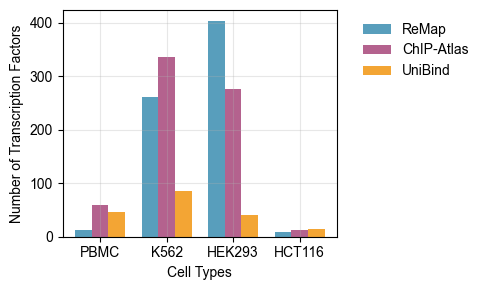

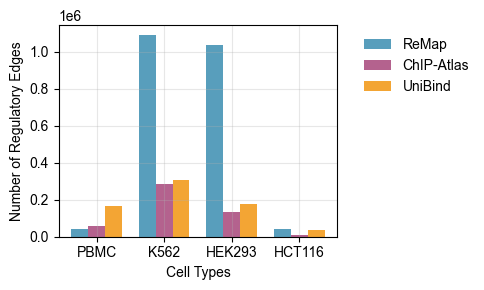

In [46]:
gt_pretty_names = {
    'remap2022': 'ReMap',
    'chipatlas': 'ChIP-Atlas', 
    'unibind': 'UniBind'
}

# Colors for ground truth types
colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
gt_colors = dict(zip(['remap2022', 'chipatlas', 'unibind'], colors))

# Get cell types in order
cell_types = list(cell_types_info.keys())
x = np.arange(len(cell_types))
width = 0.25

# Create TF counts plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for i, gt_type in enumerate(['remap2022', 'chipatlas', 'unibind']):
    gt_data = stats_df[stats_df['ground_truth'] == gt_type]
    values = []
    for cell_type in cell_types:
        cell_data = gt_data[gt_data['cell_type'] == cell_type]
        if len(cell_data) > 0:
            values.append(cell_data['n_tfs'].iloc[0])
        else:
            values.append(0)
    
    bars = ax.bar(x + i * width, values, width, 
                  label=gt_pretty_names[gt_type], 
                  color=gt_colors[gt_type], alpha=0.8)
    

ax.set_xlabel('Cell Types')
ax.set_ylabel('Number of Transcription Factors')
ax.set_xticks(x + width)
ax.set_xticklabels(cell_types)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Create Edge counts plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for i, gt_type in enumerate(['remap2022', 'chipatlas', 'unibind']):
    gt_data = stats_df[stats_df['ground_truth'] == gt_type]
    values = []
    for cell_type in cell_types:
        cell_data = gt_data[gt_data['cell_type'] == cell_type]
        if len(cell_data) > 0:
            values.append(cell_data['n_edges'].iloc[0])
        else:
            values.append(0)
    
    bars = ax.bar(x + i * width, values, width, 
                  label=gt_pretty_names[gt_type], 
                  color=gt_colors[gt_type], alpha=0.8)

ax.set_xlabel('Cell Types')
ax.set_ylabel('Number of Regulatory Edges')
ax.set_xticks(x + width)
ax.set_xticklabels(cell_types_info)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()


OVERLAP ANALYSIS FOR PBMC


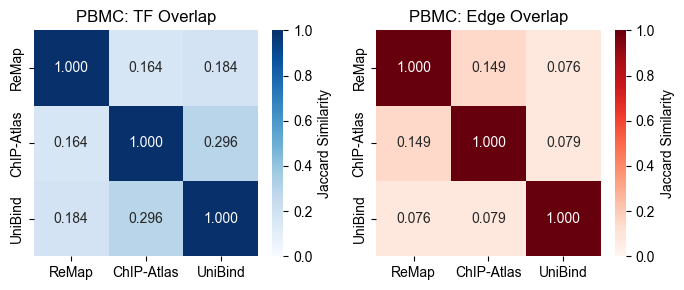


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.164
  ReMap ∩ UniBind: 0.184
  ChIP-Atlas ∩ UniBind: 0.296

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.149
  ReMap ∩ UniBind: 0.076
  ChIP-Atlas ∩ UniBind: 0.079

Unique TF counts:
  ReMap: 12 TFs
  ChIP-Atlas: 59 TFs
  UniBind: 46 TFs

Unique edge counts:
  ReMap: 42917 edges
  ChIP-Atlas: 56695 edges
  UniBind: 166947 edges

OVERLAP ANALYSIS FOR K562


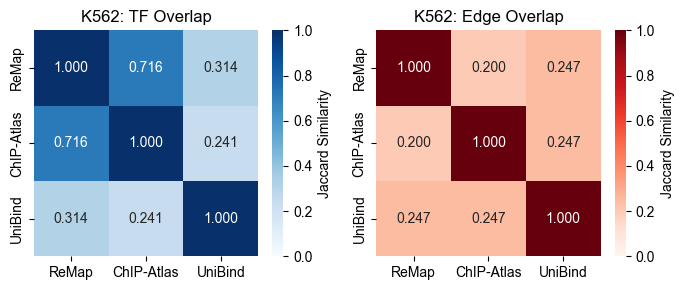


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.716
  ReMap ∩ UniBind: 0.314
  ChIP-Atlas ∩ UniBind: 0.241

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.200
  ReMap ∩ UniBind: 0.247
  ChIP-Atlas ∩ UniBind: 0.247

Unique TF counts:
  ReMap: 261 TFs
  ChIP-Atlas: 336 TFs
  UniBind: 86 TFs

Unique edge counts:
  ReMap: 1087856 edges
  ChIP-Atlas: 283874 edges
  UniBind: 307451 edges

OVERLAP ANALYSIS FOR HEK293


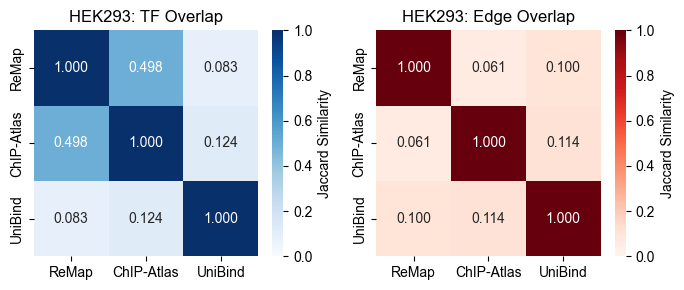


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.498
  ReMap ∩ UniBind: 0.083
  ChIP-Atlas ∩ UniBind: 0.124

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.061
  ReMap ∩ UniBind: 0.100
  ChIP-Atlas ∩ UniBind: 0.114

Unique TF counts:
  ReMap: 404 TFs
  ChIP-Atlas: 276 TFs
  UniBind: 41 TFs

Unique edge counts:
  ReMap: 1037668 edges
  ChIP-Atlas: 131309 edges
  UniBind: 177850 edges

OVERLAP ANALYSIS FOR HCT116


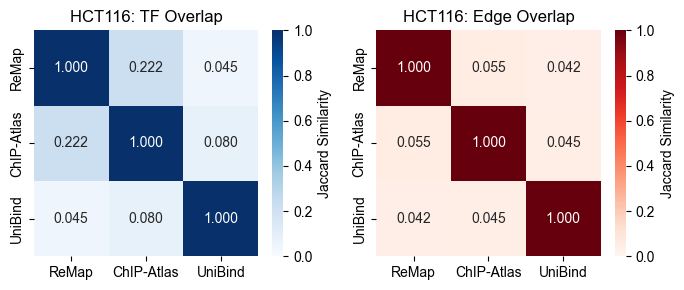


TF Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.222
  ReMap ∩ UniBind: 0.045
  ChIP-Atlas ∩ UniBind: 0.080

Edge Overlap Summary:
  ReMap ∩ ChIP-Atlas: 0.055
  ReMap ∩ UniBind: 0.042
  ChIP-Atlas ∩ UniBind: 0.045

Unique TF counts:
  ReMap: 9 TFs
  ChIP-Atlas: 13 TFs
  UniBind: 14 TFs

Unique edge counts:
  ReMap: 41042 edges
  ChIP-Atlas: 9098 edges
  UniBind: 37121 edges


In [17]:

# 2. Calculate and plot Jaccard similarity between ground truth datasets
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Calculate overlaps for each cell type
for cell_type in cell_types:
    print(f"\n{'='*60}")
    print(f"OVERLAP ANALYSIS FOR {cell_type}")
    print(f"{'='*60}")
    
    # Load the ground truth data for this cell type
    gt_data = {}
    gt_tfs = {}
    gt_edges = {}
    
    cell_info = cell_types_info[cell_type]
    
    for i, gt_type in enumerate(['remap2022', 'chipatlas', 'unibind']):
        gt_file = cell_info['gt_files'][i]
        gt_path = gt_base_path / gt_file
        
        if gt_path.exists():
            df = pd.read_csv(gt_path)
            gt_data[gt_type] = df
            gt_tfs[gt_type] = set(df['source'].unique())
            gt_edges[gt_type] = set(df.apply(lambda row: f"{row['source']}_{row['target']}", axis=1))
        else:
            gt_data[gt_type] = pd.DataFrame()
            gt_tfs[gt_type] = set()
            gt_edges[gt_type] = set()
    
    # Calculate Jaccard similarities for TFs and Edges
    gt_names = ['remap2022', 'chipatlas', 'unibind']
    pretty_names = [gt_pretty_names[gt] for gt in gt_names]
    
    # TF overlap matrix
    tf_jaccard = np.zeros((3, 3))
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            tf_jaccard[i, j] = jaccard_similarity(gt_tfs[gt1], gt_tfs[gt2])
    
    # Edge overlap matrix  
    edge_jaccard = np.zeros((3, 3))
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            edge_jaccard[i, j] = jaccard_similarity(gt_edges[gt1], gt_edges[gt2])
    
    # Create heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    
    # TF overlap heatmap
    sns.heatmap(tf_jaccard, annot=True, fmt='.3f', 
                xticklabels=pretty_names, yticklabels=pretty_names,
                cmap='Blues', vmin=0, vmax=1, ax=ax1,
                cbar_kws={'label': 'Jaccard Similarity'})
    ax1.set_title(f'{cell_type}: TF Overlap', fontsize=12, fontweight='bold')
    # ax1.set_xlabel('Ground Truth Database', fontweight='bold')
    # ax1.set_ylabel('Ground Truth Database', fontweight='bold')
    
    # Edge overlap heatmap
    sns.heatmap(edge_jaccard, annot=True, fmt='.3f',
                xticklabels=pretty_names, yticklabels=pretty_names, 
                cmap='Reds', vmin=0, vmax=1, ax=ax2,
                cbar_kws={'label': 'Jaccard Similarity'})
    ax2.set_title(f'{cell_type}: Edge Overlap', fontsize=12, fontweight='bold')
    # ax2.set_xlabel('Ground Truth Database', fontweight='bold')
    ax2.set_ylabel('', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTF Overlap Summary:")
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            if i < j:  # Only print upper triangle (avoid duplicates)
                print(f"  {gt_pretty_names[gt1]} ∩ {gt_pretty_names[gt2]}: {tf_jaccard[i,j]:.3f}")
    
    print(f"\nEdge Overlap Summary:")
    for i, gt1 in enumerate(gt_names):
        for j, gt2 in enumerate(gt_names):
            if i < j:  # Only print upper triangle (avoid duplicates)
                print(f"  {gt_pretty_names[gt1]} ∩ {gt_pretty_names[gt2]}: {edge_jaccard[i,j]:.3f}")
    
    # Print unique counts
    print(f"\nUnique TF counts:")
    for gt in gt_names:
        print(f"  {gt_pretty_names[gt]}: {len(gt_tfs[gt])} TFs")
    
    print(f"\nUnique edge counts:")
    for gt in gt_names:
        print(f"  {gt_pretty_names[gt]}: {len(gt_edges[gt])} edges")

## Scores global

In [20]:
!cd {env['TASK_GRN_INFERENCE_DIR']} && sbatch src/metrics/tf_binding/run_global.sh

Submitted batch job 9115729


In [ ]:
!ls -lt {env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/tf_binding/

total 72
-rw-r--r-- 1 jnourisa clusers 519 Nov 21 15:01 summary_global.csv
drwxr-xr-x 2 jnourisa clusers 751 Nov 20 14:24 tmp


,dataset,method,tfb_grn,tfb_all,unibind_tfb_grn_norm,unibind_tfb_all_norm,chipatlas_tfb_grn_norm,chipatlas_tfb_all_norm,remap_tfb_grn_norm,remap_tfb_all_norm
0,op,Ananse:Bone marrow,0.102873,0.035740,0.136198,0.041452,0.058165,0.018731,0.194948,0.097474
1,op,Ananse:Heart,0.024480,0.005472,0.041997,0.010043,0.008129,0.001102,0.037726,0.009432


In [18]:
# TF Binding Analysis
output_dir = f"{env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/tf_binding/"
metric = 'tf_binding'

# Ground truth sources
gt_sources = ['unibind', 'chipatlas', 'remap']

# Prettier names mapping for GT sources
gt_pretty_names = {
    'unibind': 'UniBind',
    'chipatlas': 'ChIP-Atlas',
    'remap': 'ReMap'
}

# Method ordering: inferred GRNs first, then global ones
method_order = ['negative_control', 'pearson_corr', 'grnboost', 'scenicplus', 'collectri']

df_all = pd.read_csv(f'{output_dir}/summary_global.csv')

for dataset in df_all['dataset'].unique():
    df = df_all[df_all['dataset'] == dataset].copy()
    df = df.set_index('method')
    
    # Calculate F1 score from precision (tfb_grn_norm) and recall (tfb_all_norm)
    df_f1 = pd.DataFrame(index=df.index)
    df_precision_recall = pd.DataFrame(index=df.index)
    
    for gt in gt_sources:
        precision_col = f'{gt}_tfb_grn_norm'
        recall_col = f'{gt}_tfb_all_norm'
        
        if precision_col in df.columns and recall_col in df.columns:
            precision = df[precision_col].astype(float)
            recall = df[recall_col].astype(float)
            
            # F1 = 2 * (precision * recall) / (precision + recall)
            # Handle division by zero
            f1 = 2 * (precision * recall) / (precision + recall)
            f1 = f1.fillna(0)  # If both precision and recall are 0
            
            pretty_gt = gt_pretty_names.get(gt, gt)
            df_f1[f'F1 ({pretty_gt})'] = f1
            df_precision_recall[f'Precision ({pretty_gt})'] = precision
            df_precision_recall[f'Recall ({pretty_gt})'] = recall
    
    # Order methods: specified ones first, then the rest
    available_methods = df_f1.index.tolist()
    ordered_methods = [m for m in method_order if m in available_methods]
    remaining_methods = [m for m in available_methods if m not in method_order]
    final_method_order = ordered_methods + remaining_methods
    
    # Prepare F1 dataframe
    df_f1 = df_f1.reindex(final_method_order)
    df_f1.index = df_f1.index.map(lambda x: surrogate_names.get(x, x))
    
    # Prepare Precision/Recall dataframe and sort columns
    df_precision_recall = df_precision_recall.reindex(final_method_order)
    df_precision_recall.index = df_precision_recall.index.map(lambda x: surrogate_names.get(x, x))
    # Sort columns: all precision first, then all recall
    precision_cols = [col for col in df_precision_recall.columns if 'Precision' in col]
    recall_cols = [col for col in df_precision_recall.columns if 'Recall' in col]
    df_precision_recall = df_precision_recall[precision_cols + recall_cols]
    
    # Plot F1 heatmap
    fig, ax = plt.subplots(figsize=(1*len(df_f1.columns), .4*len(df_f1)))
    plot_heatmap(df_f1, name='',  cmap="viridis", ax=ax)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)

    
    # Plot Precision and Recall heatmap
    fig, ax = plt.subplots(figsize=(1*len(df_precision_recall.columns), .4*len(df_precision_recall)))
    plot_heatmap(df_precision_recall, name='',  cmap="viridis", ax=ax)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)

    
    # Separate plot for TF coverage (number of TFs in GT and evaluated)
    # Get TF coverage columns (number of TFs, not percentage)
    n_tfs_in_gt_cols = [col for col in df.columns if 'n_tfs_in_gt' in col]
    n_tfs_evaluated_cols = [col for col in df.columns if 'n_tfs_evaluated' in col]
    
    if n_tfs_in_gt_cols or n_tfs_evaluated_cols:
        coverage_data = pd.DataFrame(index=df.index)
        
        # Add TFs in ground truth
        for gt in gt_sources:
            col = f'{gt}_n_tfs_in_gt'
            if col in df.columns:
                pretty_gt = gt_pretty_names.get(gt, gt)
                coverage_data[f'{pretty_gt} (in GT)'] = df[col].astype(float)
        
        # Add TFs evaluated (available in GRN)
        for gt in gt_sources:
            col = f'{gt}_n_tfs_evaluated'
            if col in df.columns:
                pretty_gt = gt_pretty_names.get(gt, gt)
                coverage_data[f'{pretty_gt} (in GRN)'] = df[col].astype(float)
        
        if not coverage_data.empty:
            coverage_data = coverage_data.reindex(final_method_order)
            coverage_data.index = coverage_data.index.map(lambda x: surrogate_names.get(x, x))
            fig, ax = plt.subplots(figsize=(.8*len(coverage_data.columns), .4*len(coverage_data)))
            plot_heatmap(coverage_data, name='',  cmap="plasma", ax=ax)
            ax.set_xlabel('', fontsize=12)
            ax.set_ylabel('', fontsize=12)

EmptyDataError: No columns to parse from file

## Scores datasets

In [21]:
!cd {env['TASK_GRN_INFERENCE_DIR']} && sbatch src/metrics/tf_binding/run_local.sh

Submitted batch job 9115733


In [ ]:
datasets = ['xaira_HEK293T', 'xaira_HCT116', 'replogle', 'norman',  'adamson', 'op',  "300BCG", "ibd_cd", "ibd_uc", 'parsebioscience']
ground_truths = ['remap2022', 'chipatlas', 'unibind']

for dataset in datasets:
    all_results = []  
    for gt in ground_truths:
        try:
            df = pd.read_csv(f'{RESULTS_DIR}/tf_binding/summary_{dataset}_{gt}.csv')
        except FileNotFoundError:
            continue
        df = df.pivot(index='method', columns='metric', values='value')
        try:
            df = df[['tfb_grn', 'tfb_all',
                     'n_tfs_evaluated']]
        except KeyError as e:
            print(f"Missing columns in {dataset} - {gt}: {e}")
            continue
        metric_cols = [c for c in df.columns if c != 'n_tfs_evaluated']
        df_norm = df[metric_cols].copy()
        for c in metric_cols:
            min_val, max_val = df_norm[c].min(), df_norm[c].max()
            if max_val > min_val:
                df_norm[c] = (df_norm[c] - min_val) / (max_val - min_val)
            else:
                df_norm[c] = 0  
        for c in metric_cols:
            df[f'{c}_norm'] = df_norm[c]
        
        df['ground_truth'] = gt
        all_results.append(df.reset_index())
    if not all_results:
        print(f"No valid results found for {dataset}")
        continue
    combined = pd.concat(all_results, ignore_index=True)
    def weighted_mean(x):
        weights = x['n_tfs_evaluated']
        result = {}
        for c in x.columns:
            if c in ['tfb_grn', 
                     'tfb_all']:
                result[c] = (x[c] * weights).sum() / weights.sum()
        return pd.Series(result)
    summary = (
        combined
        .groupby('method')
        .apply(weighted_mean)
        .reset_index()
    )
    lift_cols = ['tfb_grn', 'tfb_all']
    
    # Apply min-max normalization to lift columns before averaging
    lift_normalized = summary[lift_cols].copy()
    for col in lift_cols:
        min_val, max_val = lift_normalized[col].min(), lift_normalized[col].max()
        if max_val > min_val:
            lift_normalized[col] = (lift_normalized[col] - min_val) / (max_val - min_val)
        else:
            lift_normalized[col] = 0
    
    summary['Overall'] = lift_normalized.mean(axis=1)
    summary = summary.sort_values('Overall', ascending=False)
    summary = summary.set_index('method')
    summary.index = summary.index.map(lambda name: surrogate_names.get(name, name))
    summary.columns = summary.columns.map(lambda name: surrogate_names.get(name, name))
    fig, ax = plt.subplots(1 , 1, figsize=(2.5, 3.5) if dataset in ['op', 'ibd'] else (2.5, 2.5))

    plot_heatmap(summary, name=f'{dataset}_summary', cmap="viridis", ax=ax)
    plt.title(f'{surrogate_names.get(dataset, dataset)}', pad=15)
    ax.set_ylabel('')
    os.makedirs(f'{figs_dir}/tf_binding', exist_ok=True)
    plt.savefig(f"{figs_dir}/tf_binding/{dataset}.png", dpi=200, transparent=True, bbox_inches='tight')

No valid results found for xaira_HEK293T
No valid results found for xaira_HCT116
No valid results found for replogle
No valid results found for norman
No valid results found for adamson
No valid results found for op
No valid results found for 300BCG
No valid results found for ibd
No valid results found for parsebioscience


# GB vs ridge in metrics

### Runs

In [7]:
reg_type = 'GB'  # 'ridge'
dataset = 'op'
net_folder = RESULTS_DIR.split('task_grn_inference')[1].replace('resources', '').strip('/')
publish_dir = f"s3://openproblems-data/resources/grn/{net_folder}"
save_dir = F"{publish_dir}/experiment/gb_vs_ridge/"
publish_dir

's3://openproblems-data/resources/grn/results'

In [4]:
!cd {TASK_GRN_INFERENCE_DIR} && bash scripts/run_grn_evaluation.sh --dataset={dataset} --run_local=false --reg_type={reg_type} --save_dir={save_dir} --build_images=false 


DATASET: op
PREDICTION: none
RUN_TEST: false
BUILD_IMAGES: false
RUN_LOCAL: false
reg_type: GB
Publish dir: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/
Available methods:
celloracle
figr
geneformer
granie
grnboost
negative_control
pearson_corr
portia
positive_control
ppcor
scenic
scenicplus
scglue
scgpt
scprint
Parameter file created: ./params/op_evaluation.yaml
upload: params/op_evaluation_param_local.yaml to s3://openproblems-data/resources/grn/results/params/op_evaluation_param_local.yaml

  Workflow 2UDrBBB61S1VI5 submitted at [openproblems-bio / openproblems-bio] workspace.

    https://cloud.seqera.io/orgs/openproblems-bio/workspaces/openproblems-bio/watch/2UDrBBB61S1VI5



### Post

In [8]:
!aws s3 sync {save_dir} {RESULTS_DIR}/experiment/gb_vs_ridge/ --no-sign-request

download: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/score_uns.yaml to ../../task_grn_inference/resources/results/experiment/gb_vs_ridge/score_uns.yaml
download: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/trace.txt to ../../task_grn_inference/resources/results/experiment/gb_vs_ridge/trace.txt
download: s3://openproblems-data/resources/grn/results/experiment/gb_vs_ridge/metric_configs.yaml to ../../task_grn_inference/resources/results/experiment/gb_vs_ridge/metric_configs.yaml


In [9]:
from src.helper import read_yaml
scores_gb = read_yaml(f"{RESULTS_DIR}/experiment/gb_vs_ridge/score_uns.yaml").set_index('model').drop(columns=['dataset'])
scores_ridge = read_yaml(f"{RESULTS_DIR}/op/score_uns.yaml").set_index('model').drop(columns=['dataset'])

[{'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'figr', 'metric_ids': ['replica_consistency_precision', 'replica_consistency_balanced'], 'metric_values': [1.0128060022168346, 7.489606690132838]}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'scprint', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'None', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'portia', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'granie', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'scglue', 'metric_ids': ['key', 'value'], 'metric_values': ['None', 'None']}, {'dataset_id': 'op', 'date_created': '30-10-2025', 'file_size': 23048, 'method_id': 'scprint', 'metric_ids': ['sem_p

In [ ]:
scores_gb = scores_gb[['r2-theta-0.1', 'r2-theta-0.5', 'r2-theta-1.0']]
scores_ridge = scores_ridge[['r2-theta-0.1', 'r2-theta-0.5', 'r2-theta-1.0']]

[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, ''),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, ''),
 Text(0, 10.5, ''),
 Text(0, 11.5, '')]

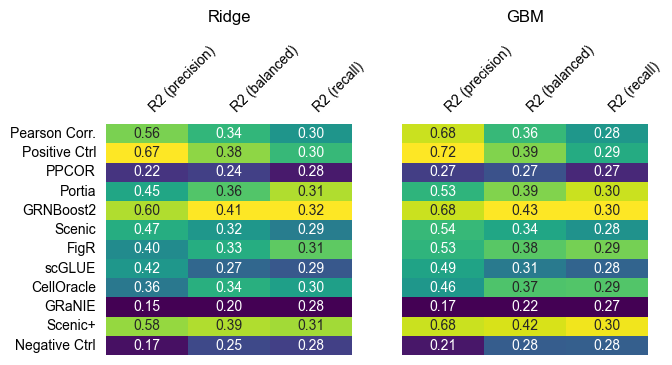

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)
ax = axes[0]
plot_raw_scores(scores_ridge, ax)
ax.set_xlabel('')
ax.set_title('Ridge', pad=15, weight='bold')

ax = axes[1]
plot_raw_scores(scores_gb, ax)
ax.set_title('GBM', pad=15, weight='bold')
ax.set_xlabel('')
ax.set_yticklabels([])

## Post

In [ ]:
# - GB vs ridge
scores_mat_ridge = pd.read_csv(f'', index_col=0)
scores_mat_GB = pd.read_csv(f'', index_col=0)

scores_mat_n = scores_mat_GB/scores_mat_ridge
scores_mat_n = scores_mat_n.drop(['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
def plot_gb_vs_ridge(ax):
    import seaborn as sns
    scores_mat_n_all_long = scores_mat_n.reset_index().melt(id_vars='index')
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surrogate_names)
    scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surrogate_names)

    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative performance \n (GB to Ridge)')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.1, .1), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_gb_vs_ridge(ax)
fig.savefig(f"{results_folder}/figs/gb_vs_ridge.png", dpi=300, transparent=True, bbox_inches='tight')

# Normalization effect

In [3]:
dataset = 'op'

### Run

In [ ]:
# !cd ../ && sbatch scripts/experiment_normalization.sh $dataset 

Submitted batch job 9103080


### Post analysis

In [4]:
output_dir = f"{RESULTS_DIR}/experiment/normalization"
output_file = f"{output_dir}/metrics_{dataset}.csv"

In [5]:
!ls -lt {output_dir}

total 14312
-rw-r--r-- 1 jnourisa clusers   11162 Nov 27 12:48 metrics_op.csv
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 12:47 op.ppcor.ppcor.prediction_score_defualt.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 12:12 op.scenic.scenic.prediction_score_defualt.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 11:49 op.grnboost.grnboost.prediction_score_defualt.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 11:23 op.pearson_corr.pearson_corr.prediction_score_defualt.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 10:57 op.portia.portia.prediction_score_defualt.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 10:24 op_ppcor_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 09:51 op_scenic_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 09:27 op_grnboost_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 09:01 op_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers   27144 Nov 27 08:38 op_portia_prediction_score.h

In [ ]:
output = pd.read_csv(output_file)

def map_method(pred_str):
    for m in METHODS:
        if m.lower() in str(pred_str).lower():
            return m
    return "unknown"

def map_normalizaton_method(pred_str):
    if 'defualt' in str(pred_str).lower():
        return 'SLA'
    else:
        return 'PR'

# Apply mapping
output["method"] = output["prediction"].apply(map_method)
output["normalization"] = output["prediction"].apply(map_normalizaton_method)
output.drop('prediction', axis=1, inplace=True)

cols = ['method', 'normalization'] + METRICS
output = output[[c for c in cols if c in output.columns]]

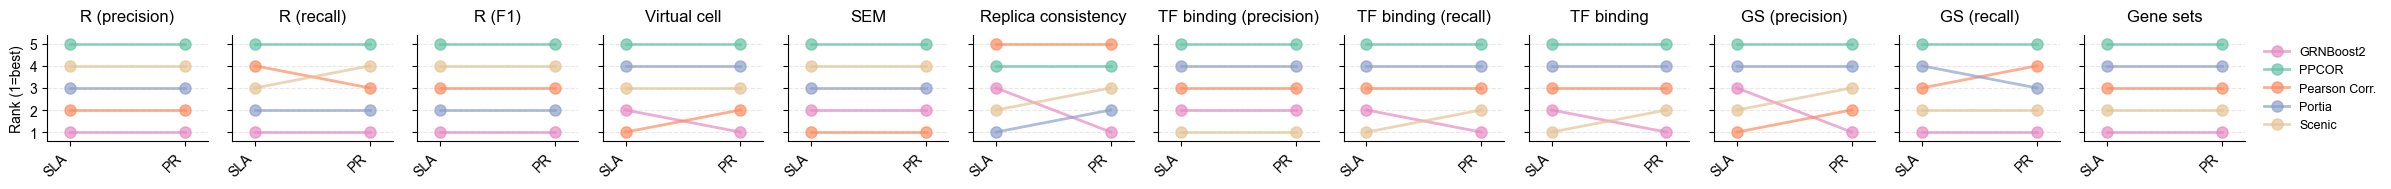

In [7]:
# Option 1: Side-by-side ranking plot (Slope/Bump chart)
def plot_ranking_comparison(output_df, metrics=None, norm_methods=['SLA', 'PR']):
    """
    Show how method rankings compare across normalization methods.
    Stable rankings indicate stable comparative performance.
    """
    metrics = [c for c in metrics if c in output_df.columns]
    n_metrics = len(metrics)
    n_norms = len(norm_methods)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(2*n_metrics, 2), sharey=True)
    if n_metrics == 1:
        axes = [axes]
    for idx, metric in enumerate(metrics):
        if metric not in output_df.columns:
            continue
        ax = axes[idx]
        ranking_data = []
        for norm in norm_methods:
            subset = output_df[output_df['normalization'] == norm][['method', metric]].copy()
            subset = subset.sort_values(metric, ascending=False)
            subset['rank'] = range(1, len(subset) + 1)
            subset['normalization'] = norm
            ranking_data.append(subset[['method', 'rank', 'normalization']])
        ranking_df = pd.concat(ranking_data)
        ranking_df['method'] = ranking_df['method'].map(lambda name: surrogate_names.get(name, name))
        ranking_pivot = ranking_df.pivot(index='method', columns='normalization', values='rank')
        # ranking_pivot = ranking_pivot[['SLA', 'PR']]  # Ensure consistent order
        for method in ranking_pivot.index:
            if all(pd.notna(ranking_pivot.loc[method])):
                ax.plot(
                    range(n_norms), 
                    ranking_pivot.loc[method].values,
                    marker='o', 
                    label=method,
                    color=palette_methods.get(method, 'gray'),
                    alpha=0.7,
                    linewidth=2,
                    markersize=8
                )
        ax.set_xticks(range(n_norms))
        ax.set_xticklabels([surrogate_names.get(n, n) for n in norm_methods], rotation=0)
        ax.set_ylabel('Rank (1=best)' if idx == 0 else '')
        ax.set_xlabel('')
        ax.set_title(surrogate_names.get(metric, metric), pad=10, fontweight='bold')
        ax.invert_yaxis()  # Lower rank (1) at top
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines[['top', 'right']].set_visible(False)
        valid_ranks = sorted(ranking_df['rank'].unique())
        ax.set_yticks(valid_ranks)
        ax.margins(x=0.2, y=0.1)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        if idx == n_metrics - 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=9)

    plt.tight_layout()
    return fig
fig1 = plot_ranking_comparison(output, metrics=METRICS[:])
# fig1 = plot_ranking_comparison(output, metrics=METRICS)
# plt.savefig(f'{figs_dir}/normalization_ranking_comparison.png', dpi=300, transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'Pearson residuals')

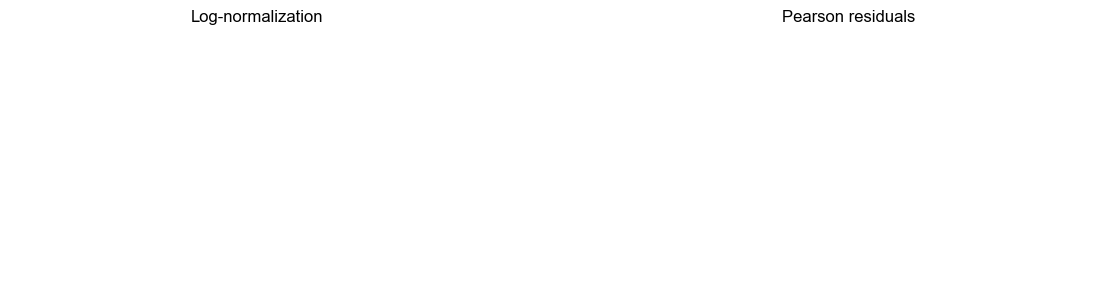

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(1*len(output.columns), 3), sharey=False)
def plot_raw_scores(scores_mat, ax):
    scores_mat = scores_mat.dropna(how='all', axis=1)
    
    available_methods = [method for method in METHODS if method in scores_mat.index]
    scores_mat = scores_mat.loc[available_methods]
    # scores_mat.index = scores_mat.index.map(lambda name: surrogate_names.get(name, name))
    # scores_mat.columns = scores_mat.columns.map(lambda name: surrogate_names.get(name, name))
    
    
    plot_heatmap(scores_mat.fillna(0), name='', ax=ax, cmap="viridis")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_ylabel('')
ax = axes[0]
plot_raw_scores(output[output['normalization']=='lognorm'].drop('normalization', axis=1).set_index('method'), ax)
ax.set_title('Log-normalization', pad=15, weight='bold')
ax = axes[1]
plot_raw_scores(output[output['normalization']=='pearson_residual'].drop('normalization', axis=1).set_index('method'), ax)
ax.set_yticklabels([])
ax.set_title('Pearson residuals', pad=15, weight='bold')


# Permutation analysis

### Run

In [ ]:
# !cd ../ && sbatch scripts/experiment_permutation.sh replogle
# !cd ../ && sbatch scripts/experiment_permutation.sh op

Submitted batch job 9191859


### Post

#### functions

In [34]:
from src.exp_analysis.post_permutation import main as main_permut
# main_permut(METRICS, dataset)

Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_link_selected.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_sign_selected.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_direction_selected.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_weight_selected.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_direction_selected.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/permutation_TF_gene_weight_selected.png


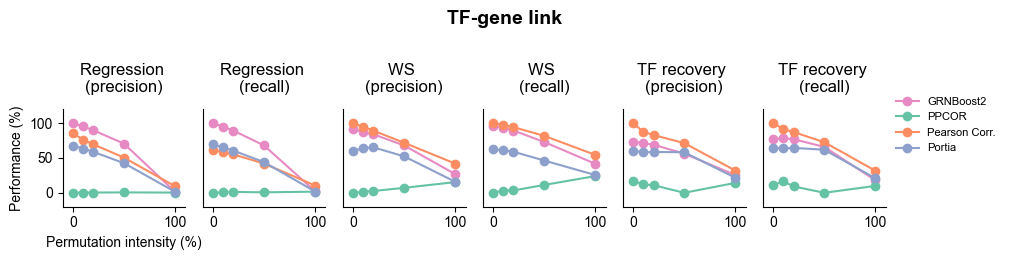

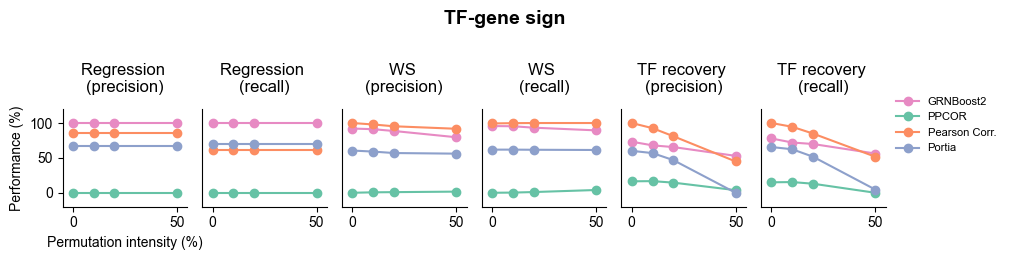

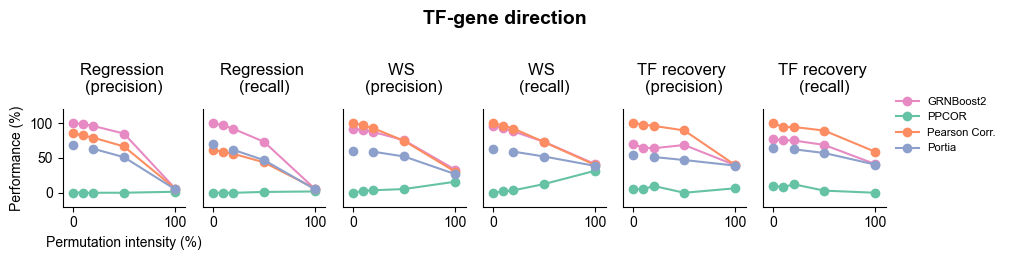

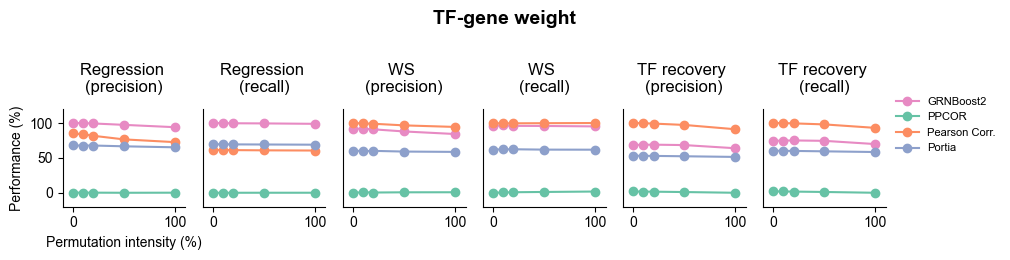

In [4]:
from src.exp_analysis.post_permutation import plot_metrics_as_axes
plot_metrics_as_axes(['r_precision', 'r_recall', 'ws_precision', 'ws_recall', 't_rec_precision', 't_rec_recall'], dataset='replogle', save_tag='selected')

In [ ]:
# plot_metrics_as_axes(FINAL_METRICS, dataset=dataset)

#### Results

In [9]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
# def plot_stacked_bar(df_all, ax, col='TF-gene connections'):
#     def normalize(df):
#         df = df.set_index('Degree')
#         df['share'] = 0
#         baseline = df.loc[0, 'r2score']
#         for i, degree in enumerate(df.index):
#             if degree == 0:
#                 share = 0
#             else:
#                 share = 100*np.abs(df.loc[degree, 'r2score'] - baseline)/baseline
#                 df.loc[degree, 'share'] = share - previous_degree
#             previous_degree = share
#         return df
#     df_all = df_all.groupby(['Permute type', 'model']).apply(normalize).reset_index(level='Degree').drop(columns='r2score')
#     df_all['Degree'] = df_all['Degree'].astype('category')
#     df = df_all[df_all['Permute type'] == col].drop(columns='Permute type')
#     df.pivot(index='model', columns='Degree', values='share').plot(kind='bar', stacked=True,  ax=ax, color=palette_celltype)
#     ax.get_legend().remove()
#     ax.set_ylabel("R² score decline (%)")
#     ax.set_xlabel("")
#     ax.set_title(col, pad=12)
#     ax.tick_params('x', rotation=45)
#     for label in ax.get_xticklabels():
#         label.set_ha('right')  # Set horizontal alignment to 'left'
#         # plt.title("Drop in R² Score by Degree for Each Model")
#     legend = ax.legend(title="Permutation\n   intensity", bbox_to_anchor=(1.05, 1), frameon=False)

In [ ]:
# def plot_robustness(reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction, axes):
#     reg_mat_net['Permute type'] = 'TF-gene connections'
#     reg_mat_sign['Permute type'] = 'TF-gene sign'
#     reg_mat_weight['Permute type'] = 'TF-gene regulatory weight'
#     reg_mat_direction['Permute type'] = 'TF-gene direction'

#     # Concatenate the DataFrames
#     df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction])
#     df_concat = df_concat.drop(columns=['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
    
#     df_concat.columns = df_concat.columns.map(lambda name: surrogate_names.get(name, name))

#     # Reset the index so that noise degree remains a column
#     df_concat.reset_index(inplace=True, drop=False)
#     df_concat.rename(columns={'index': 'Degree'}, inplace=True)

#     df_melt = pd.melt(df_concat, id_vars=['Degree', 'Permute type'], 
#                     var_name='method', value_name=r'R$^2$ score')

#     df_melt = df_melt[df_melt.method != 'Degree']

#     # Create subplots for each 'Permute type'
#     permute_types = df_melt['Permute type'].unique()
    

#     if len(permute_types) == 1:
#         axes = [axes]  # Ensure axes is always a list even if there's only one subplot

#     for i, permute_type in enumerate(permute_types):
#         ax = axes[i]
#         # Filter data for the current 'Permute type'
#         subset = df_melt[df_melt['Permute type'] == permute_type]

#         # Create a bar plot for each subset
#         sns.barplot(
#             data=subset, 
#             x='method', 
#             y=r'R$^2$ score', 
#             hue='Degree', 
#             ax=ax, 
#             palette=palette_celltype
#         )

#         # Rotate the x-axis labels and remove x-label
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#         ax.set_xlabel('')

#         # Set the title for each subplot
#         # ax.set_title(f'({chr(97 + i)}) {permute_type}', fontsize=12, pad=20)
#         ax.set_title(f'{permute_type}', fontsize=12, pad=20)

#         # Adjust margins and layout for the plot
#         ax.margins(x=0.05)
#         for side in ['right', 'top']:
#             ax.spines[side].set_visible(False)
#         ax.get_legend().remove()

#     # Move the legend outside

#     # plt.tight_layout()
#     # plt.subplots_adjust(top=0.85)  # Adjust the top space for the suptitle
# fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
# # Example usage:
# plot_robustness(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, reg1_mat_direction, axes)
# # plt.suptitle('Permutation analysis, Regression 1', y=1.1, fontsize=14, fontweight='bold')
# for ax in axes:
#     ax.set_xticklabels([])
# plt.legend(title="Degree", bbox_to_anchor=(1.05, .8), loc='upper left', frameon=False)


# plt.savefig(f"{results_folder}/figs/robustness_reg1.png", dpi=300, transparent=True, bbox_inches='tight')
# fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
# plot_robustness(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, reg2_mat_direction, axes)
# # plt.suptitle('Permutation analysis, Regression', y=1.1, fontsize=14, fontweight='bold')
# for ax in axes:
#     ax.set_title('')
# # plt.subplots_adjust(
# #     left=0.1,  # Space from the left edge of the figure
# #     right=0.95,  # Space from the right edge of the figure
# #     top=0.9,  # Space from the top of the figure
# #     bottom=0.1,  # Space from the bottom of the figure
# #     hspace=0.3,  # Height (vertical) space between rows
# #     wspace=.3   # Width (horizontal) space between columns
# # )

# # plt.savefig(f"{results_folder}/figs/robustness_reg2.png", dpi=300, transparent=True, bbox_inches='tight')

# Imputation analysis

In [68]:
dataset = 'op'
os.makedirs(f"{RESULTS_DIR}/experiment/imputation/", exist_ok=True)

### Run

In [21]:
!cd ../ && sbatch scripts/experiment_imputation.sh $dataset 

Submitted batch job 9086530


In [69]:
!ls -lt {RESULTS_DIR}/experiment/imputation/

total 5738784
-rw-r--r-- 1 jnourisa clusers      23048 Nov 18 12:58 op_original_grnboost_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers        918 Oct 31 09:42 metrics_op_pearson_corr.csv
-rw-r--r-- 1 jnourisa clusers      23048 Oct 31 09:42 op_magic_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers      23048 Oct 31 09:25 op_knn_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers      23048 Oct 31 09:14 op_original_pearson_corr_prediction_score.h5ad
-rw-r--r-- 1 jnourisa clusers    7211800 Sep  7 19:46 op_original_grnboost_prediction.h5ad
-rw-r--r-- 1 jnourisa clusers 3123867748 Sep  6 17:31 op_magic_rna.h5ad
-rw-r--r-- 1 jnourisa clusers 1734404368 Sep  6 17:28 op_knn_rna.h5ad
-rw-r--r-- 1 jnourisa clusers  670473732 Sep  6 11:58 op_original_rna.h5ad
-rw-r--r-- 1 jnourisa clusers    1618363 Sep  5 23:07 regulators_consensus_op.json
-rw-r--r-- 1 jnourisa clusers    7244568 Sep  5 23:07 op_magic_pearson_corr_prediction.h5ad
-rw-r--r-- 1 jnourisa clusers

### Post

In [72]:
inference_method = 'pearson_corr'

rr = pd.read_csv(f"{RESULTS_DIR}/experiment/imputation/metrics_{dataset}_pearson_corr.csv")
# rr = rr[rr['inference_method'] == inference_method]
names = rr['prediction'].str.split('/').str[-1].values
names = [f.split('_')[1] for f in names]
rr['prediction'] = names
rr.set_index('prediction', inplace=True)
mapping_ = { 
    'original':'Single-cell', 'magic': 'Magic imput.', 'knn': 'KNN imput.'
}
rr.index = rr.index.map(mapping_)
rr.columns = rr.columns.map(lambda name: surrogate_names.get(name, name))
rr


,r2-theta-0.0,R (balanced),R (recall),SEM (precision),SEM (balanced),RC (precision),RC (balanced)
prediction,,,,,,,
Single-cell,0.559804,0.340728,0.297496,1.390759,126.231123,1.011625,12.486802
KNN imput.,0.146563,0.227708,0.271289,0.644892,-0.000000,1.001349,6.458031
Magic imput.,0.558178,0.348468,0.300812,1.556994,168.112162,1.013233,8.665843


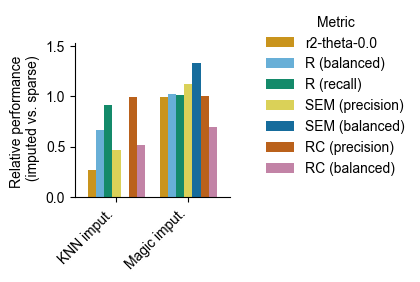

In [73]:
single_cell_row = rr.loc['Single-cell']
def plot_imput_vs_singlecell(ax):
    normalized_df = rr.div(single_cell_row, axis=1)
    normalized_df.drop('Single-cell', inplace=True)
    scores_mat_n_all_long = normalized_df.reset_index().melt(id_vars='prediction')
    sns.barplot(scores_mat_n_all_long, x='prediction', y='value', hue='variable', ax=ax, palette=colors_blind)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(r'Relative R$^2$ scores')
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharey=False)
plot_imput_vs_singlecell(ax)
ax.get_legend().remove()
ax.set_ylabel('Relative performance \n (imputed vs. sparse)')
ax.margins(x=.1)
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc=(1.2, .1), title='Metric', frameon=False)
# fig.savefig(f"{results_folder}/figs/imput_vs_singlecell.png", dpi=300, transparent=True, bbox_inches='tight')

# Global nets

### Get global nets

In [ ]:
!cd ../ && python src/process_data/pereggrn/acquisition.py 

### Run

In [6]:
dataset = 'op'

In [16]:
!cd ../ && sbatch scripts/experiment_global_grns.sh $dataset

Submitted batch job 9103099


### Post

In [14]:
# !ls -lt {RESULTS_DIR}/experiment/global_grns/

In [4]:
from src.utils.config import FINAL_METRICS
metrics_all = pd.read_csv(f'{RESULTS_DIR}/experiment/global_grns/metrics_op.csv').fillna(0)
metrics_all['model'] = metrics_all['model'].apply(lambda x: x.replace('.csv', ''))
metrics_all['model'] = metrics_all['model'].apply(lambda x: ':'.join(x.split(':')[:2]) if ':' in x else x)
def extract_tissue_name(x):
    if ':' not in x:
        return x
    method_part = x.split(':')[0]
    tissue_part = x.split(':')[1].strip()
    if tissue_part.lower().startswith('whole blood'):
        tissue_name = 'Blood'
    elif tissue_part.lower().startswith('bone'):
        tissue_name = 'Bone marrow'
    else:
        tissue_name = tissue_part.split()[0]
    return f"{method_part}: {tissue_name}"
metrics_all['model'] = metrics_all['model'].apply(extract_tissue_name)
metrics_all = metrics_all[[c for c in FINAL_METRICS if c in metrics_all.columns] + ['model']]
metrics_all.style.background_gradient(cmap='Blues') 

,r_precision,r_recall,vc,sem,rc_tf_act,tfb_f1,gs_f1,model
0,0.252716,0.232492,0.500014,0.004446,0.235675,0.000000,0.003030,negative_control
1,0.493073,0.262954,0.632085,0.086057,0.358531,0.034959,0.406921,pearson_corr
2,0.562296,0.319771,0.634835,0.069784,0.618476,0.092486,0.610697,grnboost
3,0.536691,0.329395,0.598691,0.047500,0.539425,0.036202,0.514172,scenicplus
4,0.244267,0.223324,0.538740,0.019297,0.468515,0.000000,0.538077,collectri
5,0.256102,0.236213,0.519545,0.072722,0.080121,0.053050,0.500545,Ananse: Bone marrow
6,0.225805,0.216780,0.538893,0.000000,0.454188,0.001447,0.266702,Gtex: Lung
7,0.234674,0.217495,0.549103,0.000000,0.521463,0.065000,0.243316,Gtex: Blood
8,0.215366,0.214703,0.537201,0.000000,0.440481,0.017476,0.092442,Gtex: Breast
9,0.208494,0.209902,0.298469,0.000000,0.062469,0.000000,0.000000,Cellnet: Skin


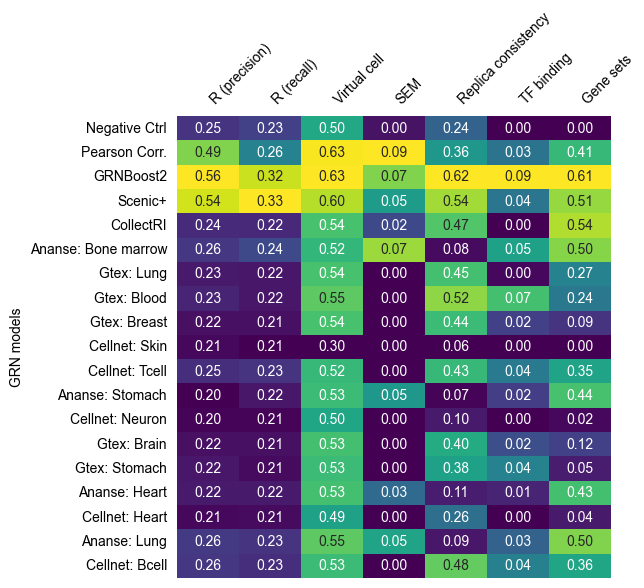

In [5]:
from src.helper import plot_heatmap
fig, ax = plt.subplots(1, 1, figsize=(.7*len(metrics_all.columns), 6), sharey=False)
if 'model' in metrics_all.columns:
    metrics_all.set_index('model', inplace=True)
metrics_all.index = metrics_all.index.map(lambda x: surrogate_names.get(x, x))
metrics_all.columns = metrics_all.columns.map(lambda x: surrogate_names.get(x, x))
plot_heatmap(metrics_all, name='', ax=ax, cmap="viridis")
ax.set_ylabel('GRN models')
fig.savefig(f"{figs_dir}/evaluation_scores_global_models.png", dpi=300, transparent=True, bbox_inches='tight')

# Analysis of pseudobulking

## Granular pseudobulking

### Run

In [23]:
!cd ../ && sbatch scripts/experiment_granular.sh

Submitted batch job 9086532


In [23]:
!ls -lt {RESULTS_DIR}/experiment/granular_pseudobulk/metrics_op.csv

-rw-r--r-- 1 jnourisa clusers 1675 Nov  1 01:48 /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/experiment/granular_pseudobulk/metrics_op.csv


### Post

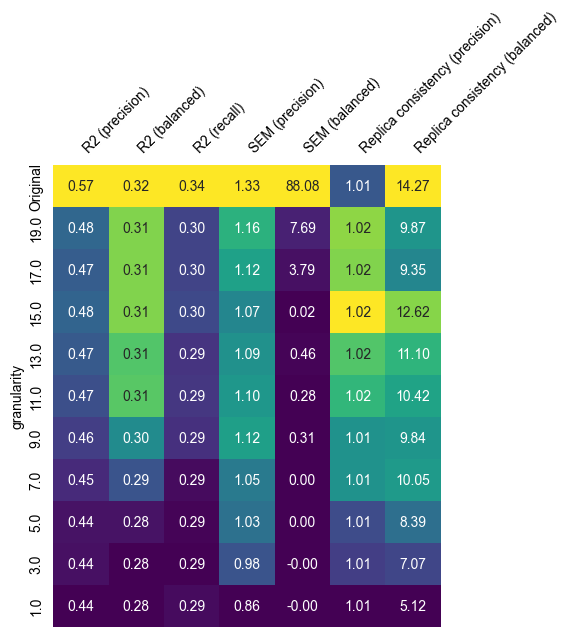

In [25]:
scores_mat = pd.read_csv(f'{RESULTS_DIR}/experiment/granular_pseudobulk/metrics_op.csv').drop(columns=['dataset'])
scores_mat.columns = scores_mat.columns.map(lambda name: surrogate_names.get(name, name))
mask = scores_mat['granularity'] == -1
scores_mat.loc[mask, 'granularity'] = np.inf
scores_mat = scores_mat.sort_values(by='granularity', ascending=False)


scores_mat.index = scores_mat['granularity']
scores_mat.index = scores_mat.index.map(lambda name: 'Original' if name == np.inf else name)
scores_mat = scores_mat.drop(columns=['granularity'])
fig, ax = plt.subplots(1, 1, figsize=(5, 6), sharey=False)
# scores_mat = scores_mat.reindex(index=degrees)
plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surrogate_names[dataset]}\n(Effect of pseudobulking)", pad=10, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

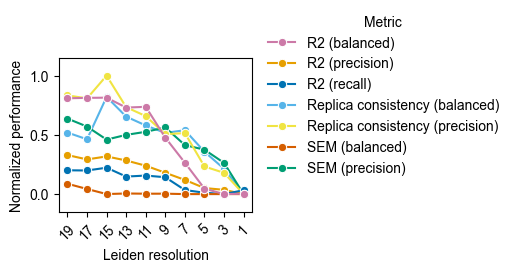

In [27]:
def plot_line_pseudobulking_effect(scores_mat, ax):
    scores_mat = scores_mat.reset_index()
    df_melted = scores_mat.melt(
        id_vars='granularity', var_name='Method', value_name='Score'
    )

    # Apply min-max normalization per method
    df_melted['Normalized Score'] = df_melted.groupby('Method')['Score'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
    )

    df_melted = df_melted[df_melted['granularity'] != 'Original']
    df_melted['granularity'] = df_melted['granularity'].astype(float)
    df_melted = df_melted.sort_values('granularity', ascending=False)

    sns.lineplot(
        data=df_melted,
        x='granularity',
        y='Normalized Score',
        hue='Method',
        marker='o',
        ax=ax,
        palette=colors_blind,
    )
    ax.set_ylabel('Normalized performance')
    ax.set_xlabel('Leiden resolution')
    ax.margins(y=0.15)

    # Reorder legend alphabetically
    handles, labels = ax.get_legend_handles_labels()
    order = np.argsort(labels)
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles, labels, title='Metric', loc=(1.05, .2), frameon=False)

    xticks = sorted(df_melted['granularity'].unique(), reverse=True)
    xticks_int = [int(np.round(x)) for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_int, rotation=45)
    ax.invert_xaxis()  # largest values on the left

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_line_pseudobulking_effect(scores_mat, ax)
fig.savefig(f"{RESULTS_DIR}/figs/evaluation_scores_imputation_lineplot.png", dpi=300, transparent=True, bbox_inches='tight')

## Bulk vs sc

### Run

In [22]:
!cd ../ && sbatch scripts/experiment_sc_vs_bulk.sh

Submitted batch job 9086531


### post

In [75]:
!ls -lt {env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/bulk_vs_sc/

total 6472
-rw-r--r-- 1 jnourisa clusers 7228184 Nov 18 12:32 replogle.prediction_bulk.h5ad
-rw-r--r-- 1 jnourisa clusers 7228184 Nov 18 12:32 replogle.prediction_sc.h5ad
-rw-r--r-- 1 jnourisa clusers     595 Nov  5 16:37 metrics_replogle.csv


In [74]:
df_all = []
for dataset in ['replogle', 'xaira_HCT116', 'xaira_HEK293T']:
    df_d = pd.read_csv(f"{env['TASK_GRN_INFERENCE_DIR']}/resources/results/experiment/bulk_vs_sc/metrics_{dataset}.csv")
    df_all.append(df_d)
df_all = pd.concat(df_all, ignore_index=True)
df_all.style.background_gradient()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jnourisa/projs/ongoing/task_grn_inference//resources/results/experiment/bulk_vs_sc/metrics_xaira_HCT116.csv'

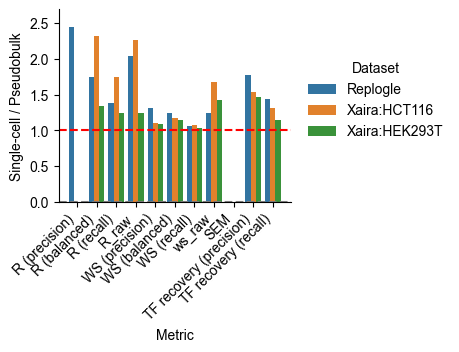

In [8]:
df = df_all.copy()

sc = df[df['data_type'] == 'sc'].set_index('dataset')
bulk = df[df['data_type'] == 'bulk'].set_index('dataset')
diff = sc.drop('data_type', axis=1) / \
       bulk.drop('data_type', axis=1)
diff = diff.reset_index().melt(id_vars='dataset', var_name='metric', value_name='sc_minus_bulk')
diff['dataset'] = diff['dataset'].map(lambda name: surrogate_names.get(name, name))
diff['metric'] = diff['metric'].map(lambda name: surrogate_names.get(name, name))

fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
sns.barplot(data=diff, x='metric', y='sc_minus_bulk', hue='dataset', ci=None, ax=ax)
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
plt.ylabel('Single-cell / Pseudobulk')
plt.xlabel('Metric')
plt.margins(y=0.1, x=0.05)
# plt.title('Difference between Single-cell (SC) and Bulk per Metric')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', loc=[1.05, .3], frameon=False)
ax.spines[['top', 'right']].set_visible(False)
plt.savefig(f"{figs_dir}/evaluation_scores_sc_vs_bulk_barplot.png", dpi=300, transparent=True, bbox_inches='tight')

# Datasets stats

In [7]:
from src.exp_analysis.post_datasets_stats import main_datasets_stats, main_gene_wise, main_perturbation_effects
# main_datasets_stats()

### Gene wise evaluation

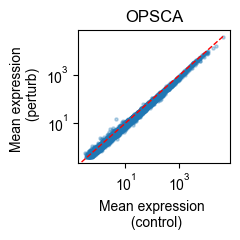

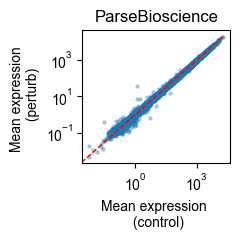

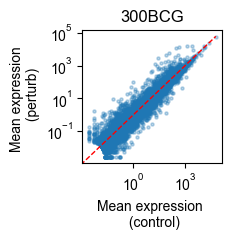

KeyboardInterrupt: 

In [5]:
main_gene_wise()

### Sample wise evaluation

['OPSCA' 'Replogle' 'Nakatake' 'Norman' 'adamson' 'Xaira:HCT116'
 'Xaira:HEK293T' 'ParseBioscience' 'ibd' '300BCG']
perturbation_effects_all_datasets  /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/datasets_stats/perturbation_effects_all_datasets.png


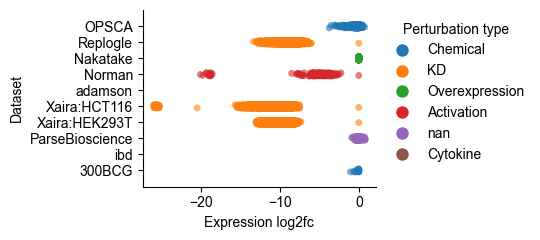

In [8]:
main_perturbation_effects()

# Metrics consensus stats

In [ ]:
from src.exp_analysis.post_consensus_stats import main_consensus_regression, main_ws
main_consensus_regression()
main_ws()

ws_consensus_all: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/figs/consensus_regulators/ws_consensus_all.png


# Metrics piece-wise analysis
Analysis for OP and replogle.
Set to replogle if WS distance is evaluated.

## Funcs

In [6]:
os.makedirs(f'{RESULTS_DIR}/experiment/metrics_stability', exist_ok=True)


from statsmodels.stats.multitest import multipletests
def bh_adjust(pvals):
    # multipletests returns adjusted pvals in index 1 when method='fdr_bh'
    _, adj, _, _ = multipletests(pvals, method='fdr_bh')
    return adj

def pval_to_stars(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''

def plot_model_comparison_with_significance( df,
    control_model="pearson_corr",
    y_label='WS distance',
    model_order=None,
    per_theta=False,
    q_low=0.01,
    q_high=0.99,
    col_wrap=4,
    s=5,
    figsize=(12, 6),
    cmap='viridis',
    jitter_strength=0.12,
    random_state=0,
    test_type='ttest',
    value_col='ws_distance_pc', ylim=None):
    import math
    import numpy as np

    # 1) compute median per (model, theta, source) if not already aggregated
    if not set(['model', 'theta', 'source']).issubset(df.columns):
        raise ValueError("df must contain 'model','theta','source' columns")
    assert control_model in df['model'].unique(), f"control_model '{control_model}' not found in df['model']"
    df_med = (
        df
        .groupby(['model', 'theta', 'source'], as_index=False)
        .agg({value_col: 'median', 'present_edges_n': 'median'})
    )
    df_med['present_edges_q'] = df_med['present_edges_n'].rank(method='average', pct=True)
    df_med['present_edges_q_clipped'] = np.clip((df_med['present_edges_q'] - q_low) / (q_high - q_low), 0.0, 1.0)
    cmap_obj = plt.get_cmap(cmap)
    norm = plt.Normalize(vmin=0, vmax=1)
     
    np.random.seed(random_state)
    def compute_pvals(sub_df):
        models = [m for m in sub_df['model'].unique() if m != control_model]
        pvals = []
        tested_models = []
        ctrl_vals = sub_df.loc[sub_df['model'] == control_model, value_col].dropna().values
        for m in models:
            vals = sub_df.loc[sub_df['model'] == m, value_col].dropna().values
            
            if len(ctrl_vals) < 2 or len(vals) < 2:
                raise ValueError(f"Not enough data to perform statistical test between control model '{control_model}' and model '{m}'")
            else:
                if test_type=='ttest':
                    from scipy.stats import ttest_ind
                    _, p = ttest_ind(ctrl_vals, vals, equal_var=False)
                else:
                    from scipy.stats import mannwhitneyu
                    _, p = mannwhitneyu(ctrl_vals, vals, alternative='greater')
                
            pvals.append(p)
            tested_models.append(m)
        if len(pvals) == 0:
            return pd.DataFrame(columns=['model','pval','pval_adj','stars'])
        pvals = np.array(pvals, dtype=float)
        adj = bh_adjust(pvals)
        out = pd.DataFrame({'model': tested_models, 'pval': pvals, 'pval_adj': adj})
        out['stars'] = out['pval_adj'].apply(pval_to_stars)
        return out
    # --------- PER-THETA plots -------------
    thetas = sorted(df_med['theta'].unique())
    n = len(thetas)
    ncols = min(col_wrap, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=False)
    # ensure axes is always a 1D iterable
    if nrows * ncols == 1:
        axes = np.array([axes])
    elif nrows == 1 or ncols == 1:
        axes = np.ravel(axes)
    all_sig_dfs = []
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    i_plot = 0
    for ax, theta in zip(axes.flatten(), thetas):
        sub = df_med[df_med['theta'] == theta]
        if sub.empty:
            ax.axis('off')
            continue
        sig_df_theta = compute_pvals(sub)
        print(sig_df_theta)
        all_sig_dfs.append((theta, sig_df_theta))

        sns.boxplot(data=sub, x='model', y=value_col, order=model_order,
                    fliersize=0, ax=ax,  boxprops=dict(facecolor='none', edgecolor='black'))
        
        x = sub['model'].map({m:i for i,m in enumerate(model_order)}).values
        x_jitter = x + np.random.normal(loc=0.0, scale=jitter_strength, size=len(x))
        sc = ax.scatter(x_jitter, sub[value_col].values,
                        # c=sub['present_edges_q_clipped'].values, 
                        c='black',
                        cmap=cmap_obj, norm=norm,
                        s=s, alpha=0.9, edgecolors='none')

        # annotate stars for this theta
        sig_map_theta = {row['model']: row['stars'] for _, row in sig_df_theta.iterrows()}
        ymax_all = sub[value_col].max()
        ymin_all = sub[value_col].min()
        offset = (ymax_all - ymin_all) * 0.1 if (ymax_all > ymin_all) else 0.01
        for i, model in enumerate(model_order):
            if model == control_model:
                continue
            star = sig_map_theta.get(model, '')
            subset_ymax = sub.loc[sub['model'] == model, value_col].max()
            if np.isnan(subset_ymax):
                subset_ymax = ymax_all
            y = subset_ymax + offset
            ax.text(i, y, star, ha='center', va='bottom', fontsize=14, color='red', weight='bold')
        ax.set_title(f"{surrogate_names.get(theta, theta)}", pad=15)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
        if i_plot!=0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel(y_label)
        ax.spines[['right', 'top']].set_visible(False)    
        if ylim is not None:
            ax.set_ylim(*ylim)
        i_plot+=1
    for ax in axes.flatten()[len(thetas):]:
        ax.axis('off')
    if False:
        fig.subplots_adjust(right=0.85)
        cax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
        fig.colorbar(mappable, cax=cax, label='Number of edges')
        pct_ticks = np.linspace(0.0, 1.0, 5)
        actual_vals = np.quantile(df_med['present_edges_n'].values, pct_ticks)
        cax.set_yticks(pct_ticks)
        cax.set_yticklabels([str(int(v)) for v in actual_vals])
    plt.tight_layout()
    return fig, all_sig_dfs
def plot_lowness_reg(df, x_col='WS distance (raw)', y_col='Expression fold change (abs)'):
    from scipy.stats import spearmanr, pearsonr
    spearman_corr, spearman_p = spearmanr(df[x_col], df[y_col])
    pearson_corr, pearson_p = pearsonr(df[x_col], df[y_col])

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='model',
        alpha=1,
        s=20,
        palette=palette_methods,
        ax=ax
    )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.spines[['right', 'top']].set_visible(False)

    # Model legend
    handles1, labels1 = ax.get_legend_handles_labels()
    model_legend = ax.legend(handles1, labels1, loc=(1.02, 0.5), frameon=False, title='Model')

    # Rectangle handle for correlation info
    rect_patch = mpatches.Patch(facecolor='black', edgecolor='black', linewidth=.2, 
                               )
    fit_label = f'Spearman = {spearman_corr:.2f}\n(p = {spearman_p:.2e})'
    fit_legend = ax.legend(
        [rect_patch], [fit_label],
        loc=(1.02, 0.1),
        frameon=False,
    )
    ax.add_artist(model_legend)

    sns.regplot(data=df, x=x_col, y=y_col, scatter=False, lowess=True, color='black', line_kws={'linewidth': 1})

## Regression

In [7]:
dataset = 'op' 
gene_wise_output = f'{RESULTS_DIR}/experiment/metrics_stability/{dataset}_regression.csv'

In [33]:
!cd .. && sbatch scripts/experiment_metrics_stability.sh --dataset {dataset} --gene_wise_output {gene_wise_output}

Submitted batch job 9102214


In [8]:
regression_rr = pd.read_csv(gene_wise_output, index_col=0)
regression_rr['theta'] = regression_rr['theta'].map(lambda x: surrogate_names.get(x, x))
regression_rr['model'] = regression_rr['model'].map(lambda x: surrogate_names.get(x, x))
# regression_rr.rename(columns={'ws_distance_pc':'WS distance (standardized)', 'ws_distance': 'WS distance (raw)'}, inplace=True)
df_thetas = regression_rr[regression_rr['theta']=='R (precision)']
df_raw = regression_rr[regression_rr['theta']=='r2_raw']
print(df_raw['model'].unique())
df_raw.head()
print(df_thetas.head())

['Scenic+' 'Pearson Corr.' 'GRNBoost2' 'PPCOR']
    gene        r2  n_regulators          theta    model
0    A2M  0.011657             1  R (precision)  Scenic+
1   AAK1  0.749561             1  R (precision)  Scenic+
2  ABCA1  0.758626             2  R (precision)  Scenic+
3  ABCA5  0.320214             1  R (precision)  Scenic+
4  ABCB1  0.335454             1  R (precision)  Scenic+


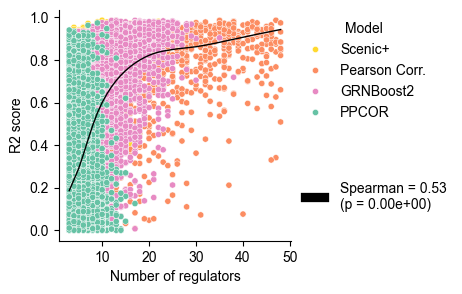

In [45]:
df = df_raw.rename({'r2': 'R2 score', 'n_regulators': 'Number of regulators'}, axis=1)
plot_lowness_reg(df[df['Number of regulators']<df['Number of regulators'].quantile(0.99)], x_col='Number of regulators', y_col='R2 score')
plt.savefig(f"{RESULTS_DIR}/figs/lowess_nreg_vs_r2.png", dpi=300, transparent=True, bbox_inches='tight')

       model           pval       pval_adj stars
0  GRNBoost2   1.000000e+00   1.000000e+00      
1      PPCOR  6.021081e-168  1.806324e-167   ***
2    Scenic+   9.999982e-01   1.000000e+00      
       model           pval       pval_adj stars
0  GRNBoost2   1.826396e-83   1.826396e-83   ***
1      PPCOR   0.000000e+00   0.000000e+00   ***
2    Scenic+  2.127897e-300  3.191845e-300   ***
       model           pval       pval_adj stars
0  GRNBoost2   1.826396e-83   1.826396e-83   ***
1      PPCOR   0.000000e+00   0.000000e+00   ***
2    Scenic+  2.127897e-300  3.191845e-300   ***


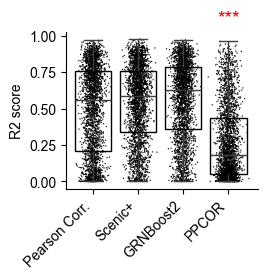

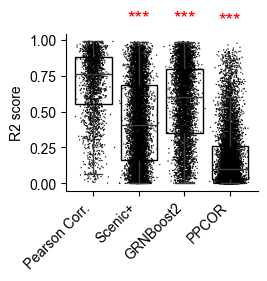

In [29]:
_ = plot_model_comparison_with_significance(df_thetas.rename({'gene':'source', 'n_regulators':'present_edges_n'}, axis=1), 
                                            model_order=['Pearson Corr.', 'Scenic+', 'GRNBoost2', 'PPCOR'],
                                            per_theta=True, 
                                            control_model='Pearson Corr.', 
                                            y_label='R2 score',
                                            value_col='r2', 
                                            figsize=(2.7, 3),
                                            s=1,
                                            test_type='mannwhitneyu',
                                            ylim=None)
plt.title('')
plt.savefig(f"{RESULTS_DIR}/figs/model_comparison_per_gene_r2.png", dpi=300, transparent=True, bbox_inches='tight')
_ = plot_model_comparison_with_significance(df_raw.rename({'gene':'source', 'n_regulators':'present_edges_n'}, axis=1), 
                                            model_order=['Pearson Corr.', 'Scenic+', 'GRNBoost2', 'PPCOR'],
                                            per_theta=True, 
                                            control_model='Pearson Corr.', 
                                            y_label='R2 score',
                                            value_col='r2', 
                                            figsize=(2.7, 3),
                                            s=1,
                                            test_type='mannwhitneyu',
                                            # ylim=(-.1, .1)
                                            )
plt.title('')
plt.savefig(f"{RESULTS_DIR}/figs/model_comparison_per_gene_r2_raw.png", dpi=300, transparent=True, bbox_inches='tight')

## Regression: feature importance

In [9]:
dataset = 'op' 
gene_wise_feature_importance = f'{RESULTS_DIR}/experiment/metrics_stability/{dataset}_regression_fi.csv'

In [ ]:
# !cd .. && sbatch scripts/experiment_metrics_stability.sh --dataset {dataset} --gene_wise_feature_importance {gene_wise_feature_importance}

Submitted batch job 9102317


In [10]:
par_reg2 = get_par(dataset)
scores_store_all_reg2 = pd.read_csv(gene_wise_feature_importance, index_col=0)
# scores_store_all_reg2 = scores_store_all_reg2[scores_store_all_reg2['model'].isin(par_reg2['grn_models'])]
scores_store_all_reg2['feature_importance_mean2std_log'] = np.log1p(scores_store_all_reg2['feature_importance_mean2std'])
scores_store_all_reg2['contextual_tf_activity'] = 1/scores_store_all_reg2['feature_importance_mean2std']
scores_store_all_reg2.head()

scores_store_all_reg2.model = scores_store_all_reg2.model.map(surrogate_names)
if 'donor_id' not in scores_store_all_reg2.columns:
    scores_store_all_reg2['donor_id'] = 'donor_0'
scores_store_all_reg2['donor_id'] = scores_store_all_reg2['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})
scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]
scores_store_all_reg2['model'].unique()

array(['Scenic+', 'Pearson Corr.', 'GRNBoost2', 'PPCOR'], dtype=object)

In [11]:
df = scores_store_all_reg2
rho, pval = stats.spearmanr(df['r2score'], df['n_regulator'])
print(f"Spearman correlation: rho={rho:.2f}, p={pval:.3e}")

Spearman correlation: rho=0.73, p=0.000e+00


### Feature stability scores

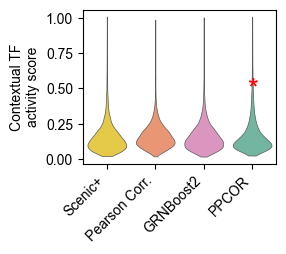

In [8]:
def plot_reg2_feature_stability_scores(scores_store_all_reg2, ax):
    from scipy.stats import mannwhitneyu
    scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]
    df_common_pivot = scores_store_present.pivot(index=['model'], columns=['donor_id','gene'], values='feature_importance_mean2std').dropna(axis=1)
    common_genes = df_common_pivot.columns.get_level_values('gene').unique()
    df = df_common_pivot
    top_95_quantile = scores_store_present['contextual_tf_activity'].quantile(0.99)
    filtered_data = scores_store_present[scores_store_present['contextual_tf_activity'] <= top_95_quantile]
    sns.violinplot(filtered_data, x='model', y='contextual_tf_activity', linewidth=0.5,  cut=-1, inner=None, ax=ax, palette=palette_methods)
    ax.set_xlabel("")
    ax.set_ylabel("Contextual TF\nactivity score")
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    sigs = ['','','','*','']
    positions = [.4]*4
    i = 0
    for ii, row_name in enumerate(range(scores_store_present['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)

### Number of regulators vs r2 scores and tf activation stability

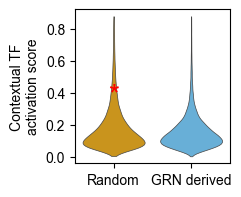

In [9]:
def plot_tf_activity_grn_derived(ax):
    top_95_quantile = scores_store_all_reg2['contextual_tf_activity'].quantile(.98)
    filtered_data = scores_store_all_reg2[scores_store_all_reg2['contextual_tf_activity'] <= top_95_quantile]
    sns.violinplot(filtered_data, x='present', y='contextual_tf_activity', linewidth=0.5,  cut=0, inner=None, ax=ax, palette=colors_blind)

    ax.set_ylabel('Contextual TF\nactivation score')

    ax.set_xlabel("")
    ax.set_xticklabels(['Random','GRN derived'])

    # plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=0)

    sigs = ['*','','','','']
    positions = [.3]*5
    i = 0
    for ii, row_name in enumerate(range(scores_store_all_reg2['model'].nunique())):
        ax.text(
            i,  # x-coordinate
            positions[ii],  # Position above the highest point in the box
            sigs[ii],  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=20,
            color='red'
        )
        i+=1
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharex=True)
plot_tf_activity_grn_derived(ax)

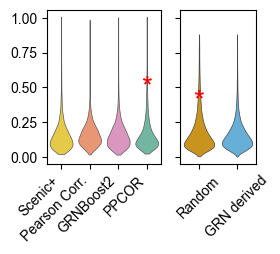

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(2.7, 2), width_ratios=[1.5, 1], sharey=True)
ax = axes[0]
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
ax.set_ylabel('')
ax = axes[1]
plot_tf_activity_grn_derived(ax)
ax.tick_params(axis='x', rotation=45)
# plt.suptitle('R2', y=1.1)
ax.set_ylabel('')
plt.savefig(f"{RESULTS_DIR}/figs/reg2_tf_activity_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

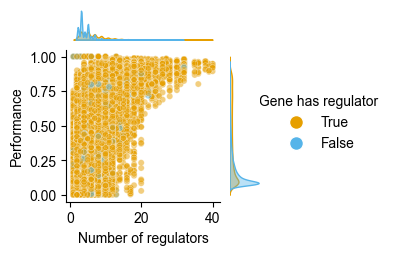

In [11]:
def plot_joint_reg2_tf_activity_vs_nregulators(scores_store_all_reg2, ax, top_plot=True):
    custom_jointplot(scores_store_all_reg2,x = 'n_regulator', 
             y = 'contextual_tf_activity', 
             hue= 'present', ax=ax, scatter_kws={'s':20})
    ax.legend(title="GRN-derived", frameon=False)
    ax.set_xlabel("Number of regulators")
    ax.set_ylabel("contextual_tf_activity")
def plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2, ax, top_plot=True):
    custom_jointplot(
        scores_store_all_reg2,
        x='n_regulator',
        y='r2score',
        hue='present',
        ax=ax,
        scatter_kws=dict(s=20, palette=palette_present),
        top_plot=top_plot
    )
    ax.set_xlabel("Number of regulators")
    ax.set_ylabel("Performance")
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), sharex=True)
palette_present = {True: colors_blind[0], False: colors_blind[1]}
plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2, ax, top_plot=True)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_present[val],
           markersize=10, label=str(val))
    for val in [True, False]
]
ax.legend(handles=legend_elements, loc=(1.22, 0.3),
          frameon=False, title="Gene has regulator")
plt.savefig(f"{RESULTS_DIR}/figs/reg2_nregulators_vs_r2scoes_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

### Similary of scores across donors

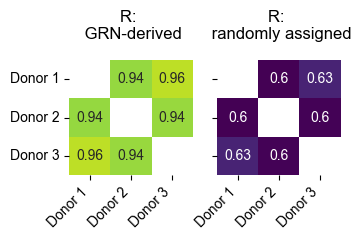

In [12]:
def plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes):
    def plot_heatmap_local(corr_matrix, ax, vmin, vmax):
        np.fill_diagonal(corr_matrix.values, np.nan)  # Optional: mask diagonal
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap="viridis", 
            cbar=False, 
            ax=ax, 
            vmin=vmin, 
            vmax=vmax
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params('y', rotation=0)
    scores_store_table = scores_store_all_reg2[scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_grn = scores_store_table.T.corr(method='spearman')
    scores_store_table = scores_store_all_reg2[~scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_random = scores_store_table.T.corr(method='spearman')
    vmin = min(corr_matrix_grn.min().min(), corr_matrix_random.min().min())
    vmax = max(corr_matrix_grn.max().max(), corr_matrix_random.max().max())
    plot_heatmap_local(corr_matrix_grn, axes[0], vmin, vmax)
    axes[0].set_title('R: \n GRN-derived', pad=15)
    axes[0].tick_params(axis='x', rotation=45)
    for label in axes[0].get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
    plot_heatmap_local(corr_matrix_random, axes[1], vmin, vmax)
    axes[1].set_title('R: \n randomly assigned', pad=15)
    axes[1].tick_params(axis='x', rotation=45)
    for label in axes[1].get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'

    # Set global title and save figure
fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.5), sharey=True)

plot_reg2_perfromance_similarity_donors(scores_store_all_reg2, axes)
# plt.suptitle('Performance correlation, Regression', fontsize=12, fontweight='bold', y=1.01)
# plt.tight_layout()
fig.savefig(
    f"{RESULTS_DIR}/figs/reg2_scores_similarity_donors_{dataset}.png", 
    dpi=300, 
    transparent=True, 
    bbox_inches='tight'
)

### Similariy of scores across models

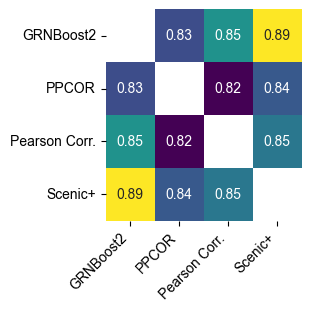

In [13]:
def plot_performance_similarity_models(df, ax, score_col='r2score'):
    scores_store_table = df[['donor_id', score_col, 'model', 'gene']].pivot(
                index='model', 
                values=score_col, 
                columns=['donor_id', 'gene']
            )

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)
plot_performance_similarity_models(scores_store_all_reg2, ax)
fig.savefig(f"{RESULTS_DIR}/figs/reg2_models_corr_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

### Joint distribution of gene wise scores

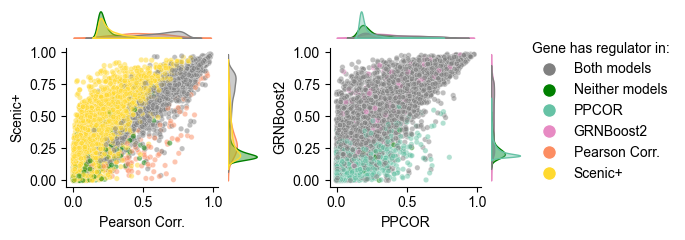

In [12]:
sys.path.append('../')
from src.helper import custom_jointplot
def plot_joint_scores(df, method1, method2, ax, value_col='r2score', col='gene'):
    scores_store_table = df.pivot_table(index=col, columns='model', values=value_col, aggfunc='mean')
    present_table = df.pivot_table(index=col, columns='model', values='present', aggfunc='mean')
    present_table = present_table.astype(bool)
    scores_store_table['present'] = 'Neither models'
    scores_store_table.loc[present_table[method1], 'present'] = method1
    scores_store_table.loc[present_table[method2], 'present'] = method2
    scores_store_table.loc[present_table[method1]&present_table[method2], 'present'] = 'Both models'
    custom_jointplot(scores_store_table,x = method1, 
             y = method2, 
             hue= 'present', ax=ax,
             scatter_kws={'s':15, 
             'palette':[color_map[name] for name in scores_store_table['present'].unique()]},
            #  'palette':[color_map[name] for name in ['Positive Ctrl', 'Pearson Corr.', 'GRNBoost2', 'PPCOR', 'None', 'Both']]},
              alpha=.5)
    return scores_store_table
color_map = {'Neither models':'green', 'Both models':'grey', **palette_methods}
figsize = (7, 2.5)
fig, axes = plt.subplots(1, 2, figsize=figsize)
ax = axes[0]
aa = plot_joint_scores(scores_store_all_reg2, 'Pearson Corr.', 'Scenic+', ax=ax)
ax.get_legend().remove()
ax = axes[1]
aa = plot_joint_scores(scores_store_all_reg2, 'PPCOR', 'GRNBoost2', ax=ax)
ax.get_legend().remove()
legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[name], markersize=10, label=name)
        for name in ['Both models', 'Neither models', 'PPCOR', 'GRNBoost2', 'Pearson Corr.', 'Scenic+' ]
    ]
ax.legend(handles=legend_elements, loc=(1.3, 0), frameon=False, title='Gene has regulator in:')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/figs/reg2_joint_r2scores_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
aaa

## WS distance

In [47]:
dataset = 'replogle'
ws_output = f'{RESULTS_DIR}/experiment/metrics_stability/{dataset}_ws.csv'

In [50]:
!cd .. && sbatch scripts/experiment_metrics_stability.sh --dataset {dataset}  --ws_output {ws_output}

Submitted batch job 9102217


In [48]:
assert dataset in ['replogle'], f"{dataset} not supported in WS analysis"
ws_rr = pd.read_csv(ws_output, index_col=0)
ws_rr['theta'] = ws_rr['theta'].map(lambda x: surrogate_names.get(x, x))
ws_rr['model'] = ws_rr['model'].map(lambda x: surrogate_names.get(x, x))
ws_rr['WS distance (standardized)'] = ws_rr['ws_distance_pc']
ws_rr['WS distance (raw)'] = ws_rr['ws_distance']
ws_thetas = ws_rr[ws_rr['theta']!='ws_raw']
ws_raw = ws_rr[ws_rr['theta']=='ws_raw']
ws_thetas.head()


,source,target,ws_distance,present_edges_n,ws_distance_pc,tf,theta,model,dataset,WS distance (standardized),WS distance (raw)
0,YBX1,AURKAIP1,0.052904,569,0.052904,YBX1,WS (raw),Scenic,replogle,0.052904,0.052904
1,YBX1,MRPL20,0.060872,569,0.060872,YBX1,WS (raw),Scenic,replogle,0.060872,0.060872
2,YBX1,ATAD3B,0.044959,569,0.044959,YBX1,WS (raw),Scenic,replogle,0.044959,0.044959
3,YBX1,GNB1,0.025859,569,0.025859,YBX1,WS (raw),Scenic,replogle,0.025859,0.025859
4,YBX1,DFFB,0.020630,569,0.020630,YBX1,WS (raw),Scenic,replogle,0.020630,0.020630


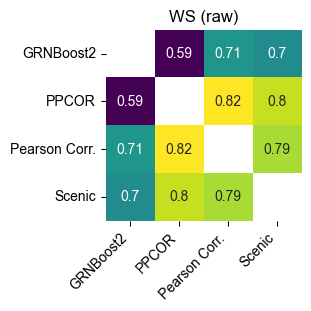

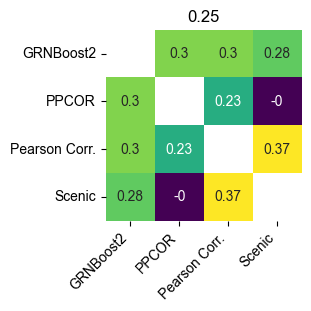

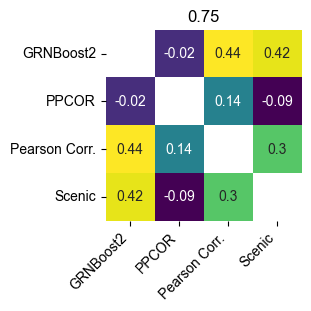

In [34]:
def plot_performance_similarity_models(df, ax, score_col='r2score'):
    scores_store_table = df[[score_col, 'model', 'source']].pivot(
                index='model', 
                values=score_col, 
                columns=['source']
            )

    spearman_corr = scores_store_table.T.corr(method='spearman')
    spearman_corr = spearman_corr.round(2)
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  
for theta in ws_thetas['theta'].unique():
    df = ws_thetas[ws_thetas['theta']==theta]
    df_mean = df.groupby(['model', 'source'], as_index=False).agg({'ws_distance_pc':'mean'})
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)
    
    plot_performance_similarity_models(df_mean, ax, score_col='ws_distance_pc')
    plt.title(theta)
# plt.tight_layout()
# fig.savefig(f"{RESULTS_DIR}/figs/reg2_models_corr_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

### Perturbation effects vs WS raw scores

In [49]:
perturb_effect_all = pd.read_csv(f'{RESULTS_DIR}/perturb_effect_all.csv')
perturb_effect_t = perturb_effect_all[perturb_effect_all['Dataset']==dataset]
df_raw_mean = ws_thetas.groupby(['model', 'tf'])['WS distance (raw)'].mean().reset_index()
df_raw_mean = df_raw_mean.merge(perturb_effect_t, left_on=['tf'], right_on=['perturbation'], how='left')
df_raw_mean = df_raw_mean[~df_raw_mean['perturbation'].isna()]

Removed top 5% outliers: 39 cases (5.06%)
WS distance threshold at 95th percentile: 0.0830


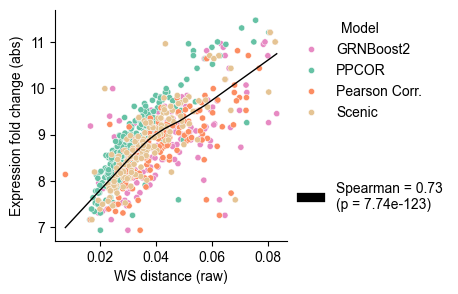

In [ ]:
# absolute fold change
df_raw_mean['Expression fold change (abs)'] = df_raw_mean['Expression fold change'].abs()

# remove nonpositive values before taking log
subset = df_raw_mean[(df_raw_mean['WS distance (raw)'] > 0) & (df_raw_mean['Expression fold change (abs)'] > 0)]

# Remove top 5% outliers (keep bottom 95%)
percentile_95 = subset['WS distance (raw)'].quantile(0.95)
n_before = len(subset)
subset = subset[subset['WS distance (raw)'] <= percentile_95]
n_after = len(subset)
print(f"Removed top 5% outliers: {n_before - n_after} cases ({(n_before - n_after)/n_before*100:.2f}%)")
print(f"WS distance threshold at 95th percentile: {percentile_95:.4f}")

plot_lowness_reg(subset, x_col='WS distance (raw)', y_col='Expression fold change (abs)')

plt.savefig(f"{RESULTS_DIR}/figs/ws_vs_perturbation_effect_{dataset}.png",
            dpi=300, transparent=True, bbox_inches='tight')

### TF wise 

       model          pval      pval_adj stars
0  GRNBoost2  7.068382e-01  7.068382e-01      
1      PPCOR  1.280320e-07  3.840960e-07   ***
2     Scenic  2.082340e-02  3.123509e-02     *
       model      pval  pval_adj stars
0  GRNBoost2  0.677275  0.677275      
1      PPCOR  0.000003  0.000008   ***
2     Scenic  0.159386  0.239079      
       model          pval      pval_adj stars
0  GRNBoost2  2.459621e-01  2.459621e-01      
1      PPCOR  4.392276e-12  1.317683e-11   ***
2     Scenic  1.330794e-04  1.996191e-04   ***
       model          pval      pval_adj stars
0  GRNBoost2  4.755366e-01  4.755366e-01      
1      PPCOR  7.513780e-23  2.254134e-22   ***
2     Scenic  2.070976e-04  3.106464e-04   ***
       model          pval      pval_adj stars
0  GRNBoost2  3.158645e-02  3.158645e-02     *
1      PPCOR  4.207681e-38  1.262304e-37   ***
2     Scenic  4.162372e-07  6.243558e-07   ***
       model          pval      pval_adj stars
0  GRNBoost2  2.459621e-01  2.459621e-01     

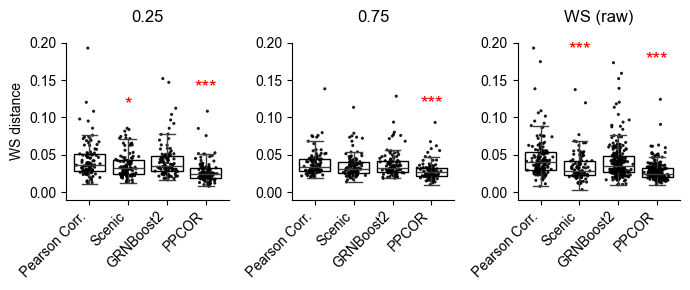

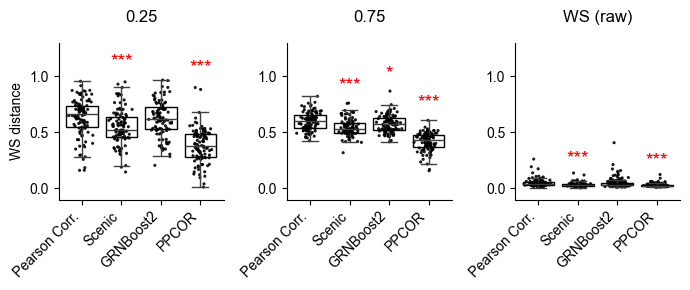

In [50]:


_ = plot_model_comparison_with_significance(ws_thetas, per_theta=True, 
                                            control_model='Pearson Corr.', 
                                            value_col='WS distance (raw)', 
                                            figsize=(7, 3),
                                            model_order=['Pearson Corr.', 'Scenic', 'GRNBoost2', 'PPCOR'],
                                            ylim=(-.01, .2)) #'WS distance (normalized)', 'WS distance'
plt.savefig(f"{RESULTS_DIR}/figs/ws_distance_comparision_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')
_ = plot_model_comparison_with_significance(ws_thetas, per_theta=True, 
                                            control_model='Pearson Corr.', 
                                            value_col='WS distance (standardized)', 
                                            figsize=(7, 3),
                                            model_order=['Pearson Corr.', 'Scenic', 'GRNBoost2', 'PPCOR'],
                                            ylim=(-.1, 1.3)) 
plt.savefig(f"{RESULTS_DIR}/figs/ws_distance_normalized_comparision_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
aaa

# Topological analysis

### Create peak gene edges

In [ ]:
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/results/op/output/sp_grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/results/op/output/figr_peak_gene.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/figr.csv')
if False: # granie extended grn
    net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/peak_gene/granie.csv')

In [ ]:
# exp_objs_dict = {}

# for model in par_reg2['grn_models']:
#     par_reg2['grn_model'] = f"{par_reg2['grn_models_dir']}/{naming_convention(dataset, model)}"
#     # if not os.path.exists(par_reg2['grn_model']):
#     #     print(model, ' is skipped')
#     #     continue
#     prediction = ad.read_h5ad(par_reg2['grn_model'])
#     net = prediction.uns['prediction']

#     print(model, len(net))
#     obj = Exp_analysis(net)
#     obj.calculate_basic_stats()
#     exp_objs_dict[model] = obj


# interaction_info = create_interaction_info(exp_objs_dict)
# # fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

In [ ]:
adata = ad.read_h5ad(retrieve_grn_path(dataset='op', model='scgpt'))
net = adata.uns['prediction']
print(len(net), net['source'].nunique(), net['target'].nunique())

400000 111 6415


In [ ]:
net['weight'] = net['weight'].astype(float)
net.sort_values('weight', key=abs, ascending=False).head(20)

,source,target,weight,cell_type
15291605,JUN,NDUFB11,0.007598,NK cells
15292998,JUN,COPS9,0.007404,NK cells
15291644,JUN,POLR2L,0.007098,NK cells
15291448,JUN,NDUFA3,0.007082,NK cells
15290782,JUN,NDUFA1,0.006866,NK cells
15291432,JUN,TMEM258,0.006852,NK cells
15291355,JUN,ATP5ME,0.006834,NK cells
15292751,JUN,HIGD2A,0.006744,NK cells
15290598,JUN,COX6C,0.006732,NK cells
15291356,JUN,COMMD6,0.006616,NK cells


### General stats

In [ ]:
from src.utils.util import read_prediction

exp_objs_dict_dict = {}
for dataset in DATASETS:
# dataset = 'op' #'op', nakatake, adamson
    par_top_analysis = {
            'grn_models': METHODS,
            'shortlist': ['pearson_corr', 'ppcor', 'portia', 'grnboost'],
            'peak_gene_models': [], #['celloracle', 'scenicplus', 'figr', 'granie'],
            'peak_gene_dir': f'{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/peak_gene/',
    }
    exp_objs_dict = {}
    nets_dict = {}
    for model in par_top_analysis['grn_models']:
        grn_file_name = retrieve_grn_path(dataset, model)
        if not os.path.exists(grn_file_name):
            print(dataset, model, ' is skipped')
            continue
        net = read_prediction(par={'prediction': grn_file_name, 'max_links': 50_000})
        nets_dict[model] = net
        if model in par_top_analysis['peak_gene_models']:
            peak_gene_net = pd.read_csv(f"{par_top_analysis['peak_gene_dir']}/{model}.csv")
        else:
            peak_gene_net = None
        print(model, len(net))
        obj = Exp_analysis(net, peak_gene_net)
        obj.calculate_basic_stats()
        obj.calculate_centrality()

        exp_objs_dict[model] = obj
    exp_objs_dict = {surrogate_names[key]:value for key,value in exp_objs_dict.items()}
    exp_objs_dict_dict[dataset] = exp_objs_dict

Original net shape:  (50000, 3)
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
pearson_corr 50000
Original net shape:  (50000, 3)
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
positive_control 50000
Original net shape:  (50000, 3)
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
ppcor 50000
Original net shape:  (400000, 4)
Prediction contains cell type specific links. Averaging weights across cell types.
Network shape after cleaning: (364253, 3)
Network shape applying max_n_links: (50000, 3)
scprint 50000
Original net shape:  (400000, 4)
Prediction contains cell type specific links. Averaging weights across cell types.
Network shape after cleaning: (255067, 3)
Network shape applying max_n_links: (50000, 3)
scgpt 50000
Original net shape:  (50000, 3)
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)
portia 50000
Original net shap

In [ ]:
for i, dataset in enumerate(DATASETS):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    links_n = {}
    source_n = {}
    target_n = {}
    nets = {}
    for name, obj in exp_objs_dict.items():
        net = obj.net
        if 'cell_type' in net.columns: # for cell specific grn models, take the mean
            n_grn = net.groupby('cell_type').size().mean()
        else:
            n_grn = len(net)

        links_n[name] = n_grn
        source_n[name] = obj.stats['n_source']
        target_n[name] = obj.stats['n_target']
    data = {
        'Model': [],
        'Count': [],
        'Type': []
    }
    for model in links_n.keys():
        data['Model'].append(model)
        data['Count'].append(links_n[model])
        data['Type'].append('Putative links')

    for model in source_n.keys():
        data['Model'].append(model)
        data['Count'].append(source_n[model])
        data['Type'].append('Putative TFs')

    for model in target_n.keys():
        data['Model'].append(model)
        data['Count'].append(target_n[model])
        data['Type'].append('Putative target genes')
    df = pd.DataFrame(data)
    df['Dataset'] = dataset
    if i == 0:
        topology_stats =df
    else:
        topology_stats = pd.concat([topology_stats, df]).reset_index(drop=True)
topology_stats['Dataset'] = topology_stats['Dataset'].map(surrogate_names)
topology_stats

,Model,Count,Type,Dataset
0,Pearson Corr.,50000,Putative links,OPSCA
1,Positive Ctrl,50000,Putative links,OPSCA
2,PPCOR,50000,Putative links,OPSCA
3,scPRINT,50000,Putative links,OPSCA
4,scGPT,50000,Putative links,OPSCA
...,...,...,...,...
250,scPRINT,16392,Putative target genes,300BCG
251,Portia,7922,Putative target genes,300BCG
252,GRNBoost2,11249,Putative target genes,300BCG
253,Scenic,11194,Putative target genes,300BCG


dict_keys(['op', 'nakatake'])


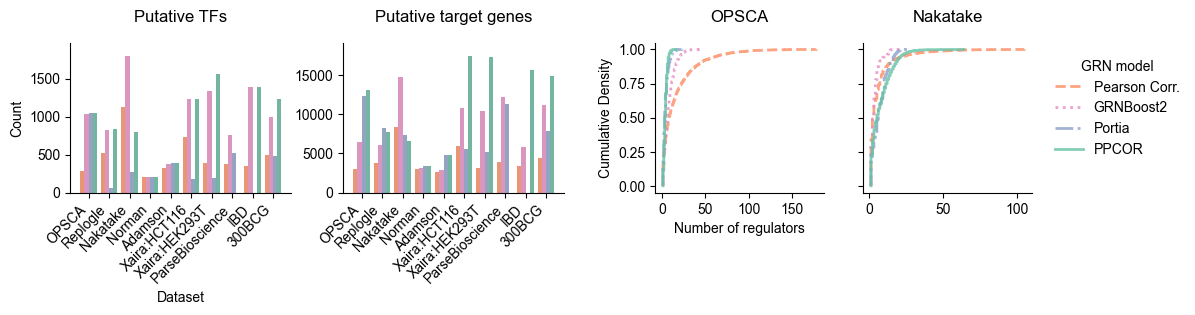

In [ ]:
order_names =[surrogate_names[name] for name in ['pearson_corr', 'grnboost', 'portia', 'ppcor']]

def plot_topology_short(axes):
    topology_stats_short = topology_stats[topology_stats['Model'].isin(order_names)]
    topology_stats_short = topology_stats_short[topology_stats_short['Type'].isin(['Putative TFs', 'Putative target genes'])]
    for i, type in enumerate(topology_stats_short['Type'].unique()):
        ax = axes[i]
        topology_stats_sub = topology_stats_short[topology_stats_short['Type']==type]
        sns.barplot(
            ax=ax,
            data=topology_stats_sub,
            hue='Model',
            hue_order=order_names,
            x='Dataset',
            y='Count',
            alpha=1,
            palette=palette_methods
        )
        ax.get_legend().remove()
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.margins(x=.05, y=.1)
        # ax.tick_params(axis='x', rotation=45)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_title(type, pad=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if i == 1:
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.set_xlabel('Dataset')
def plot_indegree_centrality(exp_objs_dict_dict, axes):
    print(exp_objs_dict_dict.keys())
    for i, dataset in enumerate(exp_objs_dict_dict.keys()):
        exp_objs_dict = exp_objs_dict_dict[dataset]
        if len(exp_objs_dict)==0:
            print(f"Skipping {dataset} as no data is available.")
            continue
        ax = axes[i]
        for name in ['pearson_corr', 'grnboost', 'portia', 'ppcor']:
            name = surrogate_names.get(name,name)
            if name not in exp_objs_dict:
                print(f"Skipping {name} as no data is available for {dataset}.")
                continue
            obj = exp_objs_dict[name]
            obj.calculate_centrality()
            values = obj.tf_gene.in_deg.degree.values

            obj.plot_cumulative_density(values, title='', x_label='Number of regulators', ax=ax, alpha=.8, label=name, c=palette_methods[name], linestyle=linestyle_methods[name], linewidth=2)
        if i != 0:
            ax.set_ylabel('')
            ax.set_xlabel('')
        ax.set_title(surrogate_names[dataset], pad=15)
        ax.grid(False)

fig = plt.figure(figsize=(13, 2))
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[0, 2]) 
ax4 = fig.add_subplot(gs[0, 3]) 
plot_topology_short([ax1, ax2])
plot_indegree_centrality({key:value for key, value in exp_objs_dict_dict.items() if key in ['op', 'nakatake']}, [ax3, ax4])
ax4.set_yticklabels([])
ax4.legend(frameon=False, loc=(1.1, .2), title='GRN model')

ax1.set_position([0.01, 0.1, 0.17, 0.75])  
ax2.set_position([0.22, 0.1, 0.17, 0.75])  
ax3.set_position([0.46, 0.1, 0.13, 0.75])
ax4.set_position([0.62, 0.1, 0.13, 0.75]) 
plt.savefig(f"{RESULTS_DIR}/figs/topology_stats.png", dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
additional_models = [model for model in topology_stats['Model'].unique() if model not in palette_methods.keys()]
palette_methods_all = {**{name:color for name, color in zip(additional_models, palette_celltype)}, **palette_methods}

In [ ]:
single_modality = ['PPCOR', 'Positive Ctrl', 'Pearson Corr.', 'Portia', 'GRNBoost2', 'Scenic', 'scPRINT', 'scGPT']

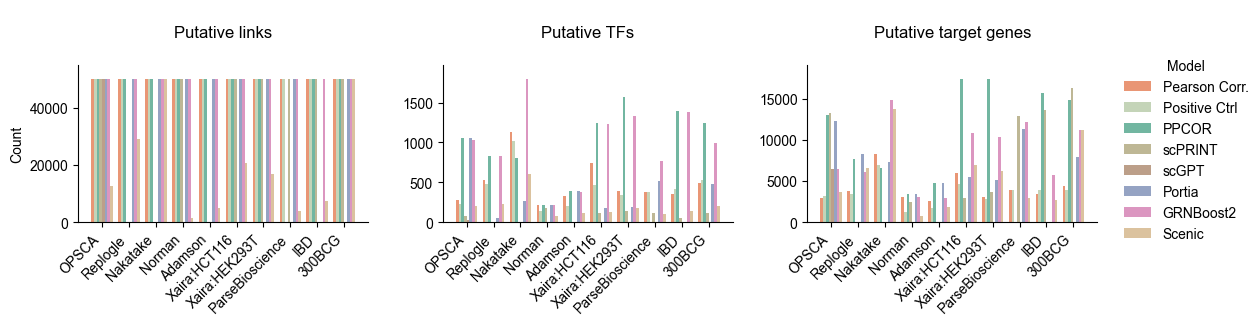

In [ ]:
g = sns.catplot(
    data=topology_stats[topology_stats['Model'].isin(single_modality)],
    kind='bar',
    hue='Model',
    # hue_order=order_names,  # Specify the desired order of hue categories
    x='Dataset',
    y='Count',
    col='Type',
    # alpha=.5,
    palette=palette_methods_all,
    sharey=False,
    height=2.5,  # Adjust plot size (smaller)
    aspect=1.5    # Adjust aspect ratio
)
g.set_axis_labels("")
for ax, col_name in zip(g.axes.flat, topology_stats['Type'].unique()):
    ax.set_title(col_name, fontsize=12, pad=20)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for ax in g.axes.flat:
    ax.margins(x=.05, y=.1)
g._legend.set_title("Model")
g._legend.set_bbox_to_anchor((1, 0.7))  
plt.savefig(f"{RESULTS_DIR}/figs/topology_stats_1.png", dpi=300, transparent=True, bbox_inches='tight')

ValueError: The palette dictionary is missing keys: {'Negative Ctrl'}

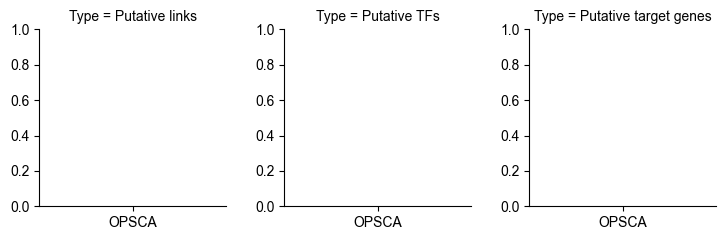

In [ ]:
g = sns.catplot(
    data=topology_stats[(~topology_stats['Model'].isin(single_modality))&(topology_stats['Dataset'].isin(['OPSCA', 'IBD_UC', 'IBD_CD']))],
    kind='bar',
    hue='Model',
    # hue_order=order_names,  # Specify the desired order of hue categories
    x='Dataset',
    y='Count',
    col='Type',
    # alpha=.5,
    palette=palette_methods_all,
    sharey=False,
    height=2.5,  # Adjust plot size (smaller)
    aspect=1    # Adjust aspect ratio
)
g.set_axis_labels("")
for ax, col_name in zip(g.axes.flat, topology_stats['Type'].unique()):
    ax.set_title(col_name, fontsize=12, pad=20) 
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for ax in g.axes.flat:
    ax.margins(x=.2, y=.1)
g._legend.set_title("Model")
g._legend.set_bbox_to_anchor((.98, 0.6))  # Adjust legend position
plt.savefig(f"{RESULTS_DIR}/figs/topology_stats_2.png", dpi=300, transparent=True, bbox_inches='tight')


## Interactions 

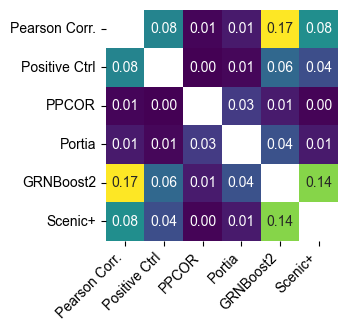

In [ ]:
def plot_jaccard_similarity(dataset, ax):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    exp_objs_dict = {key:value for key, value in exp_objs_dict.items() if key in ['Positive Ctrl', 'Pearson Corr.', 'PPCOR', 'Portia', 'GRNBoost2', 'Scenic+']}
    nets = {}
    for name, obj in exp_objs_dict.items():
        nets[name] = obj.net
    _ = jaccard_similarity_net(nets, ax=ax)
    ax.set_title(f'', pad=20, fontsize=12, fontweight='bold')
for i, dataset in enumerate(['op']):
    if dataset == 'op':
        figsize=(3, 3)
    else:
        figsize=(5, 4)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plot_jaccard_similarity(dataset, ax)
    plt.savefig(f'{RESULTS_DIR}/figs/jaccard_similarity_{dataset}.png', dpi=300, transparent=True, bbox_inches='tight')


# CRE annoation

In [ ]:
!ls {TASK_GRN_INFERENCE_DIR}/resources/grn_models/op/peak_gene

celloracle.csv	figr.csv  granie.csv  scenicplus.csv


In [ ]:
exp_objs_multiomics_dict = {}

for model in ['celloracle','scenicplus', 'figr', 'granie']:
    grn_model = f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/{dataset}/{model}.h5ad'
    peak_gene_net = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_models/op/peak_gene/{model}.csv')
    
    net = ad.read_h5ad(grn_model)
    net = net.uns['prediction']
    net['weight'] = net['weight'].astype(float)

    print(model, len(net))
    obj = Exp_analysis(net, peak_gene_net=peak_gene_net)
    obj.calculate_basic_stats()
    exp_objs_multiomics_dict[model] = obj

/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


celloracle 50000
scenicplus 41288
figr 52962
granie 50000


/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
annotation_df = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/grn_benchmark/prior/op/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_multiomics_dict.items():
    obj.annotate_peaks(annotation_df)

Not all peaks in the net is among the annotated ones. Finding the overlap


In [ ]:
annotation_dict = {}
for name, obj in exp_objs_multiomics_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
celloracle,98.5,0.6,0.3,0.2,0.1,0.0
scenicplus,35.1,34.4,17.3,6.8,4.4,1.2
figr,30.4,37.8,18.0,6.7,4.7,1.5
granie,66.2,15.8,10.4,4.0,2.3,0.9


In [ ]:
peak_annotation_df.index = peak_annotation_df.index.map(surrogate_names)

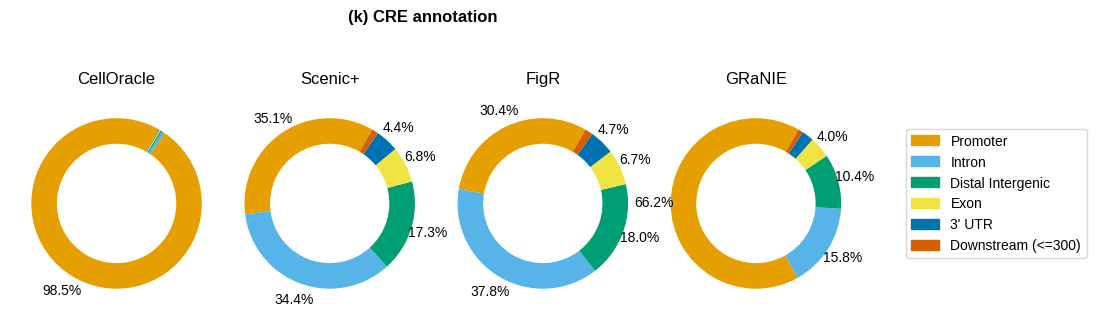

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{RESULTS_DIR}/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()